In [4]:
!gpustat -f

gpu22                Tue Jun 18 15:00:30 2024  550.54.15
[0] NVIDIA RTX A6000 | 38°C,   0 % |     3 / 49140 MB |
[1] NVIDIA RTX A6000 | 32°C,   0 % |     3 / 49140 MB |
[2] NVIDIA RTX A6000 | 45°C,   0 % |  3896 / 49140 MB | jaeeon(3890M)
 └─ 1081576 (   0%, 2944MB): /home/lr/jaeeon/anaconda3/envs/crew/bin/python -m ipykernel_launcher --f=/home/lr/jaeeon/.local/share/jupyter/runtime/kernel-v2-1076289wCn7EmDEeLjs.json
[3] NVIDIA RTX A6000 | 75°C,  99 % | 36178 / 49140 MB | tanshiyin(36172M)
 └─   3548 ( 100%, 1256MB): python primer_hf_main_modify.py --mode train --model_path ./run_saves/tsy_join_method_train_5/ --beam_size 5 --batch_size 16 --strategy auto --permute_docs False --join_method tsy_design


In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [2]:
from transformers import (
    AutoTokenizer,
    LEDForConditionalGeneration,
    AutoModelForSeq2SeqLM,
)
from datasets import load_dataset, load_metric
import torch
import nltk
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import re


rouge = load_metric("rouge")

/home/lr/tanshiyin/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1151891/1149379673.py:15: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = load_metric("rouge")
/home/lr/tanshiyin/anaconda3/envs/mds/lib/python3.9/site-packages/datasets/load.py:752: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to 

In [3]:
if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print(f"发现 {device_count} 个可用的 GPU:")
    for i in range(device_count):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    device = torch.device('cuda')
else:
    print("未发现可用的 GPU")
    device = torch.device('cpu')

发现 1 个可用的 GPU:
GPU 0: NVIDIA RTX A6000


In [308]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

    def __setattr__(self, key, value):
        self.__dict__[key] = value

    def __getattr__(self, item):
        return f"Attribute '{item}' not found."
    
    def __getitem__(self, key):
        try:
            return self.__dict__[key]
        except KeyError:
            return f"Attribute '{key}' not found."
    
    def __setitem__(self, key, value):
        self.__dict__[key] = value
    
    def __str__(self): # 作用于print输出
        attrs = [f"{key}={value}" for key, value in self.__dict__.items()]
        return f"Namespace({', '.join(attrs)})"
    
    def __repr__(self): # 作用于jupyter notebook表示
        attrs = [f"{key}={value}" for key, value in self.__dict__.items()]
        return f"Namespace({', '.join(attrs)})"

# 创建一个命名空间实例
# namespace = Namespace(x=10, y=20, z="hello")

In [295]:
dataset=load_dataset('multi_news')

/home/lr/tanshiyin/anaconda3/envs/mds/lib/python3.9/site-packages/datasets/load.py:1429: FutureWarning: The repository for multi_news contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/multi_news
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [300]:
primer_path = "allenai/PRIMERA-multinews"
tokenizer = AutoTokenizer.from_pretrained(primer_path)
model = LEDForConditionalGeneration.from_pretrained(primer_path)

/home/lr/tanshiyin/anaconda3/envs/mds/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [306]:
tokenizer.eos_token_id

2

In [913]:
dataset['train'][1]['document']

'LOS ANGELES (AP) — In her first interview since the NBA banned her estranged husband, Shelly Sterling says she will fight to keep her share of the Los Angeles Clippers and plans one day to divorce Donald Sterling. \n \n (Click Prev or Next to continue viewing images.) \n \n ADVERTISEMENT (Click Prev or Next to continue viewing images.) \n \n Los Angeles Clippers co-owner Shelly Sterling, below, watches the Clippers play the Oklahoma City Thunder along with her attorney, Pierce O\'Donnell, in the first half of Game 3 of the Western Conference... (Associated Press) \n \n Shelly Sterling spoke to Barbara Walters, and ABC News posted a short story with excerpts from the conversation Sunday. \n \n NBA Commissioner Adam Silver has banned Donald Sterling for making racist comments and urged owners to force Sterling to sell the team. Silver added that no decisions had been made about the rest of Sterling\'s family. \n \n According to ABC\'s story, Shelly Sterling told Walters: "I will fight t

### 查看dataloader后和手动process后的区别

In [307]:
from script.dataloader import get_dataloader_summ

In [310]:
args = Namespace(dataset_name="multi_news", join_method="concat_start_wdoc_global", 
                 max_length_input=4096, max_length_tgt=1024, mask_num=0, 
                 num_train_data=-1, rand_seed=0, permute_docs=False, 
                 batch_size=2, sent_sim_type="sent_transformer", num_workers=1)

In [311]:
test_dataloader = get_dataloader_summ(
    args, dataset, tokenizer, "test", args.num_workers, False
)

In [316]:
input_ids_dataloader = next(iter(test_dataloader))[0]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [323]:
PAD_TOKEN_ID = tokenizer.pad_token_id
DOCSEP_TOKEN_ID = tokenizer.convert_tokens_to_ids("<doc-sep>")
def process_document(documents):
    input_ids_all=[]
    for data in documents:
        all_docs = data.split("|||||")
        for i, doc in enumerate(all_docs):
            doc = doc.replace("\n", " ")
            doc = " ".join(doc.split())
            all_docs[i] = doc

        #### concat with global attention on doc-sep
        input_ids = []
        for i, doc in enumerate(all_docs):
            input_ids.extend(
                tokenizer.encode(
                    doc,
                    truncation=True,
                    max_length=4096 // len(all_docs),
                )[1:-1]
            )
            if i != len(all_docs) - 1:
                input_ids.append(DOCSEP_TOKEN_ID)
        input_ids = (
            [tokenizer.bos_token_id]
            + input_ids
            + [tokenizer.eos_token_id]
        )
        input_ids_all.append(torch.tensor(input_ids))
    input_ids = torch.nn.utils.rnn.pad_sequence(
        input_ids_all, batch_first=True, padding_value=PAD_TOKEN_ID
    )
    return input_ids

In [329]:
batch = dataset['test'][0]
input_ids_manully = process_document([batch['document']])

In [335]:
common_length = min(input_ids_manully[0].shape[0], input_ids_dataloader[0].shape[0])

In [337]:
torch.nonzero(input_ids_manully[0] == input_ids_dataloader[0][:common_length])

tensor([[   0],
        [   1],
        [   2],
        ...,
        [1042],
        [1043],
        [1044]])

In [342]:
input_ids_manully[0][1046], input_ids_dataloader[0][1046]

(tensor(43070), tensor(26945))

In [55]:
num_items = 10
item_embeddings = torch.rand(num_items, 4)
item_embeddings_static = item_embeddings.clone()
predicted_item_embedding = torch.rand(2,4)


In [65]:
for item_id_idx, item_id in enumerate(range(num_items)):
    print(item_id, item_id_idx)

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9


In [5]:
import random
data_idx = random.choices(range(len(dataset['test'])),k=10)
# data_idx = range(len(dataset['test']))
dataset_small = dataset['test'].select(data_idx)

In [164]:
for doc_target in dataset_small:
    docs = doc_target['document']
    target = doc_target['summary']
    
    all_docs = docs.split("|||||")
    for i, doc in enumerate(all_docs):
#         doc = doc.replace("\n", " ")
#         doc = " ".join(doc.split())
        all_docs[i] = doc
        if doc.find("Associated Press") != -1:
            print("字符串中包含 Associated Press")
        if doc.find("FILE -") != -1:
            print("字符串中包含 FILE -")
#         else:
#             print("字符串中不包含 Associated Press")
    
#     find("(Associated Press)")
    
    score=rouge.compute(predictions=all_docs[0], references=target, use_stemmer=True)

字符串中包含 Associated Press
字符串中包含 FILE -


ValueError: Mismatch in the number of predictions (36) and references (1698)

### Document和target的相似度

In [115]:
doc_idx = 0

docs = dataset['test'][doc_idx]['document']
target = dataset['test'][doc_idx]['summary']

all_docs = docs.split("|||||")
for i, doc in enumerate(all_docs):
    doc = doc.replace("\n", " ")
    doc = " ".join(doc.split())
    all_docs[i] = doc

num_docs = len(all_docs)

In [135]:
num_docs = len(all_docs)

In [76]:
# Jaccard 相似度计算target和docs之间的相似度

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score


# 将文本转换为n-gram集合
vectorizer = CountVectorizer().fit_transform(all_docs+[target])
vectors = vectorizer.toarray()

for i in range(num_docs):
    vectors[i][vectors[i]>0] = 1
vectors[-1][vectors[-1]>0] = 1

# 计算Jaccard相似度
for i in range(num_docs):
    jaccard_sim = jaccard_score(vectors[i], vectors[-1], average='binary')
    print("Jaccard Similarity:", jaccard_sim)

Jaccard Similarity: 0.16864608076009502
Jaccard Similarity: 0.17391304347826086


In [77]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# 将文本向量化
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_docs+[target])

# 计算余弦相似度
for i in range(num_docs):
    cosine_sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[-1])
    print("Cosine Similarity:", cosine_sim[0][0])


Cosine Similarity: 0.6288669160994215
Cosine Similarity: 0.6330491122822253


In [78]:
# 编辑距离（Levenshtein距离）

import Levenshtein


# 计算Levenshtein距离
for i in range(num_docs):
    levenshtein_dist = Levenshtein.distance(all_docs[i], target)
    print("Levenshtein Distance:", levenshtein_dist)

Levenshtein Distance: 4395
Levenshtein Distance: 4356


In [79]:
# BLEU分数

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

# 示例文本
reference = "The cat sat on the mat".split()
candidate = "The cat is on the mat".split()

# 使用平滑函数，平滑函数可以处理没有重叠的情况，通过对0计数的n-gram添加一个小的平滑值来避免分母为0。
smooth = SmoothingFunction()

for i in range(num_docs):
    reference = all_docs[i].split()
    candidate = target.split()
    # 计算BLEU分数
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smooth.method1)
    print("BLEU Score:", bleu_score)

BLEU Score: 0.0022353499841904303
BLEU Score: 0.0023272010157348983


In [80]:
# 句向量相似度 sentence transformer

from sentence_transformers import SentenceTransformer, util

# 加载预训练的句向量模型
model = SentenceTransformer('all-mpnet-base-v2')


# 计算文本的句向量
for i in range(num_docs):
    embedding1 = model.encode(all_docs[i], convert_to_tensor=True)
    embedding2 = model.encode(target, convert_to_tensor=True)

    # 计算余弦相似度
    cosine_sim = util.pytorch_cos_sim(embedding1, embedding2)
    print("Sentence Embedding Cosine Similarity:", cosine_sim.item())


Sentence Embedding Cosine Similarity: 0.8549716472625732
Sentence Embedding Cosine Similarity: 0.8432109355926514


### Document中的sentence和target的相似度

句子分割方式：
1. 直接用'.'进行分割，会把某些包含'.'的单词分割，不准确
2. 用nltk.sent_tokenize(text)方式，不会把单词分割，但是会把'T.I.'当作完整的句子，较准确
3. 使用spacy的模型分割，不会把'T.I.'当作完整句子，目前使用, 但是会把'Washington:'当作完整句子；尝试使用更大的模型：en_core_web_trf, en_core_web_lg，从https://spacy.io/models/en#en_core_web_sm
``` python
nlp = spacy.load("en_core_web_sm")
nlp.disable_pipe("parser")
nlp.enable_pipe("senter") # 这种设定更快，而且更准
# 处理文本
doc = nlp(text)
# 句子分割
sentences = [sent.text for sent in doc.sents]
```

In [23]:
import spacy

# 加载英文模型，用于句子分割
nlp = spacy.load("en_core_web_lg")

nlp.disable_pipe("parser")
nlp.enable_pipe("senter")

# import en_core_web_trf
# nlp = en_core_web_trf.load()

In [383]:
doc_idx = 8

docs = dataset['test'][doc_idx]['document']
target = dataset['test'][doc_idx]['summary']

all_docs = docs.split("|||||")
for i, doc in enumerate(all_docs):
    doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
#     doc = doc.replace("\n", " ")
#     doc = " ".join(doc.split())
    all_docs[i] = doc

num_docs = len(all_docs)

In [385]:
all_docs, target

(['Starting in 1996, Alexa Internet has been donating their crawl data to the Internet Archive. Flowing in every day, these data are added to the Wayback Machine after an embargo period. ',
  ' St. Paul\'s Top 3 Dive Bars"Best burger in town. Really, it\'s that amazing. Not a huge place, so don\'t bring your whole extended family with you."\n WCCO Viewers\' Choice For Best Egg Roll In MinnesotaIn this week’s Best of Minnesota, the tastiest egg rolls can be found at a popular neighborhood restaurant in northeast Minneapolis called Que Viet.\n DeRusha Eats: The Sunshine Factory Burns Bright In PlymouthThe Sunshine Factory opened in New Hope in 1976, and everything about it screamed the \'70s.\n Minneapolis Moonshine: 5 Of The City\'s Top DistilleriesWe crunched the numbers to find the top distilleries in Minneapolis, to help you find the best spots to meet your needs.\n Artsy Deals Worth Seeking Out In St. Paul This WeekLooking to up your appreciation of the arts? We\'ve rounded up three

In [81]:
all_senteces = []
senteces_id_of_doc = []
for i in range(num_docs):
    doc = all_docs[i].replace("(Associated Press)", "").replace("FILE -", "")
    # nlp，处理文本
    doc = nlp(doc)
    # 句子分割
    sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc.sents]
    all_senteces.extend(sentences)
    if len(senteces_id_of_doc)==0:
        senteces_id_of_doc.append(len(sentences))
    else:
        senteces_id_of_doc.append(len(sentences)+senteces_id_of_doc[-1])

In [65]:
tokenizer(str(next(doc.sents)))

{'input_ids': [0, 3932, 26945, 272, 5069, 287, 17646, 96, 365, 532, 8184, 21707, 50118, 2488, 7139, 1589, 1480, 939, 2488, 7139, 1589, 1480, 50118, 17646, 11, 365, 982, 40, 1339, 49, 12066, 3422, 6, 8, 1858, 2082, 15, 1349, 7, 712, 49, 1530, 30, 23, 513, 65, 6, 8, 19, 5, 801, 7, 4442, 49, 946, 7, 55, 87, 80, 12, 10224, 9, 5, 1226, 18, 299, 194, 4088, 4, 50118, 1437, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [88]:
tokenizer.encode('\'')[:2]

[0, 108]

In [86]:
tokenizer.decode(108)

"'"

In [82]:
all_senteces

["GOP Eyes Gains As Voters In 11 States Pick Governors. Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP. Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices.",
 'Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands.',
 "Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island's Gov. Lincoln Chafee is an Independent.",
 "Polls and race analysts suggest that only three of tonight's contests are considered competitive, all in states where incumbent Democratic governors aren't running again: Montana, New Hampshire and Washington.",
 'While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North Dakota and Indi

In [19]:
# Jaccard 相似度计算target和docs之间的相似度

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score


# all_senteces = []
# for i in range(num_docs):
#     sentences = nltk.sent_tokenize(all_docs[i])
#     all_senteces.extend(sentences)


    
# 将文本转换为n-gram集合
vectorizer = CountVectorizer().fit_transform(all_senteces+[target])
vectors = vectorizer.toarray()

for i in range(len(vectors)):
    vectors[i][vectors[i]>0] = 1

# 计算Jaccard相似度
doc_id = 0
for i in range(len(all_senteces)):
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    jaccard_sim = jaccard_score(vectors[i], vectors[-1], average='binary')
    print(f"doc {doc_id} sent {i}-Jaccard Similarity:", jaccard_sim)

doc 0 sent 0-Jaccard Similarity: 0.17054263565891473
doc 0 sent 1-Jaccard Similarity: 0.09009009009009009
doc 0 sent 2-Jaccard Similarity: 0.03418803418803419
doc 0 sent 3-Jaccard Similarity: 0.1282051282051282
doc 0 sent 4-Jaccard Similarity: 0.16521739130434782
doc 0 sent 5-Jaccard Similarity: 0.06779661016949153
doc 0 sent 6-Jaccard Similarity: 0.136
doc 0 sent 7-Jaccard Similarity: 0.061946902654867256
doc 0 sent 8-Jaccard Similarity: 0.04065040650406504
doc 0 sent 9-Jaccard Similarity: 0.12396694214876033
doc 0 sent 10-Jaccard Similarity: 0.049586776859504134
doc 0 sent 11-Jaccard Similarity: 0.05128205128205128
doc 0 sent 12-Jaccard Similarity: 0.06542056074766354
doc 0 sent 13-Jaccard Similarity: 0.1103448275862069
doc 0 sent 14-Jaccard Similarity: 0.09322033898305085
doc 0 sent 15-Jaccard Similarity: 0.02608695652173913
doc 0 sent 16-Jaccard Similarity: 0.04132231404958678
doc 0 sent 17-Jaccard Similarity: 0.058823529411764705
doc 0 sent 18-Jaccard Similarity: 0.045045045045045

In [20]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# all_senteces = []
# for i in range(num_docs):
#     sentences = nltk.sent_tokenize(all_docs[i])
#     all_senteces.extend(sentences)



# 将文本向量化
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_senteces+[target])

# 计算余弦相似度
doc_id = 0
for i in range(len(all_senteces)):
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    cosine_sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[-1])
    print(f"doc {doc_id} sent {i}-Cosine Similarity:", cosine_sim[0][0])


doc 0 sent 0-Cosine Similarity: 0.24102418098008926
doc 0 sent 1-Cosine Similarity: 0.23391266613631823
doc 0 sent 2-Cosine Similarity: 0.07539999655241314
doc 0 sent 3-Cosine Similarity: 0.24212850187007307
doc 0 sent 4-Cosine Similarity: 0.31950391731366007
doc 0 sent 5-Cosine Similarity: 0.1797630735667592
doc 0 sent 6-Cosine Similarity: 0.25847237481195035
doc 0 sent 7-Cosine Similarity: 0.16996419229512022
doc 0 sent 8-Cosine Similarity: 0.15341846023710742
doc 0 sent 9-Cosine Similarity: 0.3253832925427495
doc 0 sent 10-Cosine Similarity: 0.12432858888706294
doc 0 sent 11-Cosine Similarity: 0.16739494375604586
doc 0 sent 12-Cosine Similarity: 0.15355150202098913
doc 0 sent 13-Cosine Similarity: 0.19549630373574334
doc 0 sent 14-Cosine Similarity: 0.21216530513647738
doc 0 sent 15-Cosine Similarity: 0.11667598705079932
doc 0 sent 16-Cosine Similarity: 0.08548231652024595
doc 0 sent 17-Cosine Similarity: 0.13809644520701314
doc 0 sent 18-Cosine Similarity: 0.0828451291993201
doc 0 

In [21]:
# 编辑距离（Levenshtein距离）

import Levenshtein


# 计算Levenshtein距离
doc_id = 0
for i in range(len(all_senteces)):
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    levenshtein_dist = Levenshtein.distance(all_senteces[i], target)
    print(f"doc {doc_id} sent {i}-Levenshtein Distance:", levenshtein_dist)

doc 0 sent 0-Levenshtein Distance: 680
doc 0 sent 1-Levenshtein Distance: 789
doc 0 sent 2-Levenshtein Distance: 786
doc 0 sent 3-Levenshtein Distance: 734
doc 0 sent 4-Levenshtein Distance: 730
doc 0 sent 5-Levenshtein Distance: 749
doc 0 sent 6-Levenshtein Distance: 697
doc 0 sent 7-Levenshtein Distance: 792
doc 0 sent 8-Levenshtein Distance: 760
doc 0 sent 9-Levenshtein Distance: 708
doc 0 sent 10-Levenshtein Distance: 770
doc 0 sent 11-Levenshtein Distance: 766
doc 0 sent 12-Levenshtein Distance: 801
doc 0 sent 13-Levenshtein Distance: 661
doc 0 sent 14-Levenshtein Distance: 757
doc 0 sent 15-Levenshtein Distance: 797
doc 0 sent 16-Levenshtein Distance: 778
doc 0 sent 17-Levenshtein Distance: 769
doc 0 sent 18-Levenshtein Distance: 827
doc 0 sent 19-Levenshtein Distance: 762
doc 0 sent 20-Levenshtein Distance: 779
doc 0 sent 21-Levenshtein Distance: 785
doc 0 sent 22-Levenshtein Distance: 764
doc 0 sent 23-Levenshtein Distance: 821
doc 0 sent 24-Levenshtein Distance: 796
doc 0 sent

In [22]:
# BLEU分数

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu

# 使用平滑函数，平滑函数可以处理没有重叠的情况，通过对0计数的n-gram添加一个小的平滑值来避免分母为0。
smooth = SmoothingFunction()



doc_id = 0
for i in range(len(all_senteces)):
    reference = all_senteces[i].split()
    candidate = target.split()
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    # 计算BLEU分数
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smooth.method1)
    print(f"doc {doc_id} sent {i}-BLEU Score:", bleu_score)

doc 0 sent 0-BLEU Score: 0.052516537134932935
doc 0 sent 1-BLEU Score: 0.008922792017840799
doc 0 sent 2-BLEU Score: 0.0017050434639569296
doc 0 sent 3-BLEU Score: 0.004071048670237826
doc 0 sent 4-BLEU Score: 0.024833537164633254
doc 0 sent 5-BLEU Score: 0.004147175988212835
doc 0 sent 6-BLEU Score: 0.006245303961616687
doc 0 sent 7-BLEU Score: 0.003205995862201587
doc 0 sent 8-BLEU Score: 0.0034873454219144554
doc 0 sent 9-BLEU Score: 0.049667074329266515
doc 0 sent 10-BLEU Score: 0.002027649818726467
doc 0 sent 11-BLEU Score: 0.003605727923410432
doc 0 sent 12-BLEU Score: 0.03773881547728682
doc 0 sent 13-BLEU Score: 0.0042193278398767265
doc 0 sent 14-BLEU Score: 0.004931851192351146
doc 0 sent 15-BLEU Score: 0.003205995862201587
doc 0 sent 16-BLEU Score: 0.0028216345864346703
doc 0 sent 17-BLEU Score: 0.007096035310665079
doc 0 sent 18-BLEU Score: 0.0018028639617052157
doc 0 sent 19-BLEU Score: 0.003355507926125869
doc 0 sent 20-BLEU Score: 0.0034873454219144554
doc 0 sent 21-BLEU

In [71]:
# 句向量相似度 sentence transformer

from sentence_transformers import SentenceTransformer, util

# 加载预训练的句向量模型
model = SentenceTransformer('all-mpnet-base-v2')

doc_id = 0

all_cosine_sims = []
# 计算文本的句向量
for i in range(len(all_senteces)):
    embedding1 = model.encode(all_senteces[i], convert_to_tensor=True)
    embedding2 = model.encode(target, convert_to_tensor=True)
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    # 计算余弦相似度
    cosine_sim = util.pytorch_cos_sim(embedding1, embedding2)
    all_cosine_sims.append(cosine_sim.item())
    print(f"doc {doc_id} sent {i}-Sentence Embedding Cosine Similarity:", cosine_sim.item())


doc 0 sent 0-Sentence Embedding Cosine Similarity: 0.7516170144081116
doc 0 sent 1-Sentence Embedding Cosine Similarity: 0.6076449751853943
doc 0 sent 2-Sentence Embedding Cosine Similarity: 0.5492553114891052
doc 0 sent 3-Sentence Embedding Cosine Similarity: 0.5720685720443726
doc 0 sent 4-Sentence Embedding Cosine Similarity: 0.718743085861206
doc 0 sent 5-Sentence Embedding Cosine Similarity: 0.5036206841468811
doc 0 sent 6-Sentence Embedding Cosine Similarity: 0.6540898084640503
doc 0 sent 7-Sentence Embedding Cosine Similarity: 0.3216194808483124
doc 0 sent 8-Sentence Embedding Cosine Similarity: 0.4208720922470093
doc 0 sent 9-Sentence Embedding Cosine Similarity: 0.5073840022087097
doc 0 sent 10-Sentence Embedding Cosine Similarity: 0.2851841151714325
doc 0 sent 11-Sentence Embedding Cosine Similarity: 0.40695667266845703
doc 0 sent 12-Sentence Embedding Cosine Similarity: 0.6262562274932861
doc 0 sent 13-Sentence Embedding Cosine Similarity: 0.3923552930355072
doc 0 sent 14-Se

In [92]:
sorted_index = np.argsort(all_cosine_sims)[::-1]
for i in sorted_index:
    print(f"{all_cosine_sims[i]:.3f} - {all_senteces[i]}")

0.752 - GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices.
0.742 - GOP Eyes Gains As Voters In 11 States Pick Governors Jim Cole / AP i Jim Cole / AP Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, and with the potential to extend their hold to more than two-thirds of the nation's top state offices.
0.719 - While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North Dakota and Indiana.
0.719 - While those state races remain too close to call, Republicans are expected to wrest the North Carolina 

In [81]:
all_senteces

["GOP Eyes Gains As Voters In 11 States Pick Governors Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation's top state offices.",
 'Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands.',
 "Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island's Gov. Lincoln Chafee is an Independent.",
 "Polls and race analysts suggest that only three of tonight's contests are considered competitive, all in states where incumbent Democratic governors aren't running again: Montana, New Hampshire and Washington.",
 'While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North Dakota and Indian

## From original HF dataset to datasets with sentences
构建一个数据集：每个文档的内容不再是多个文档，而是多个文档的句子list，其中句子由
```python
nlp = spacy.load("en_core_web_lg")
nlp.disable_pipe("parser")
nlp.enable_pipe("senter")
```
来分割。

数据问题：
26685：document和summary是错误的

In [31]:
import csv
import json
from tqdm import tqdm
import datasets

In [12]:
import spacy

# 加载英文模型，用于句子分割
nlp = spacy.load("en_core_web_lg")

nlp.disable_pipe("parser")
nlp.enable_pipe("senter")

In [7]:
dataset = load_dataset('multi_news', trust_remote_code=True)

In [166]:
# structure: 'train'/'validation'/'test'_dict -- within_doc_id_list -- 'document'/'summary'_dict 
#             -- in_doc_id_dict -- sentence_list
dataset_sentence = {}

In [167]:
dataset_sentence['train'] = []
sentence_split_constrain = 800000

for doc_id, docs_target in tqdm(enumerate(dataset['train']), total=len(dataset['train'])):
    docs = docs_target['document']
    target = docs_target['summary']
    
    all_docs = docs.split("|||||")
    for i, doc in enumerate(all_docs):
        doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
    #     doc = doc.replace("\n", " ")
    #     doc = " ".join(doc.split())
        all_docs[i] = doc

    num_docs = len(all_docs)
    word_len = [len(d.split()) for d in all_docs]
        
    all_senteces = {}
    for i in range(num_docs):
        all_senteces[i] = []
        doc = all_docs[i].replace("(Associated Press)", "").replace("FILE -", "")
        doc = re.sub(r'\.{2,}', '-', doc)
        # whether seprate the doc, if the doc is too long
        if len(doc) > sentence_split_constrain:
            print(f"{doc_id}-th sentence is too long to fit the sentence split model")
            doc_subpart_start = 0
            doc_subpart_end = sentence_split_constrain

            while doc_subpart_end < len(doc):
                doc_subpart_end = doc_subpart_start + doc[doc_subpart_start:doc_subpart_end].rfind('.\n ')+3
                print(doc_subpart_start, doc_subpart_end, len(sentences))
                doc_subpart = doc[doc_subpart_start:doc_subpart_end]
                doc_subpart_start = doc_subpart_end
                doc_subpart_end = doc_subpart_start+sentence_split_constrain

                doc_subpart = nlp(doc_subpart)
                # 句子分割
                sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
                all_senteces[i].extend(sentences)
            # 对于最后一个subpart
            print(doc_subpart_start, "last", len(sentences))
            doc_subpart = doc[doc_subpart_start:]
            doc_subpart = nlp(doc_subpart)
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
            all_senteces[i].extend(sentences)
        else:
            # nlp，处理文本
            doc = nlp(doc)
            # 句子分割
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc.sents]
            all_senteces[i].extend(sentences)
    
    all_sentences_target = {'document': all_senteces, 'summary': target}
    dataset_sentence['train'].append(all_sentences_target)
#     print(all_senteces)
    


  1%|          | 395/44972 [01:14<2:33:34,  4.84it/s]


  2%|▏         | 785/44972 [02:24<2:39:08,  4.63it/s]


  3%|▎         | 1185/44972 [03:35<2:14:57,  5.41it/s]


  3%|▎         | 1556/44972 [04:42<1:42:13,  7.08it/s]


  4%|▍         | 1931/44972 [05:49<1:46:53,  6.71it/s]


  5%|▌         | 2309/44972 [06:59<2:01:35,  5.85it/s]


  6%|▌         | 2687/44972 [08:09<1:31:09,  7.73it/s]


  7%|▋         | 3088/44972 [09:17<1:59:01,  5.86it/s]


  8%|▊         | 3484/44972 [10:25<3:20:39,  3.45it/s]


  9%|▊         | 3899/44972 [11:33<2:24:42,  4.73it/s]


 10%|▉         | 4281/44972 [12:57<1:46:07,  6.39it/s]


 10%|█         | 4669/44972 [14:06<2:15:19,  4.96it/s]


 11%|█         | 5040/44972 [15:12<3:46:13,  2.94it/s]


 12%|█▏        | 5427/44972 [16:19<2:34:34,  4.26it/s]


 13%|█▎        | 5813/44972 [17:25<1:32:26,  7.06it/s]


 14%|█▍        | 6201/44972 [18:34<2:11:13,  4.92it/s]


 15%|█▍        | 6592/44972 [19:43<1:54:53,  5.57it/s]


 16%|█▌        | 6972/44972 [20:55<1:13:04,  8.67it/s]


 16%|█▋        | 7374/44972 [22:08<2:51:23,  3.66it/s]


 17%|█▋        | 7761/44972 [23:11<2:25:00,  4.28it/s]


 18%|█▊        | 8149/44972 [24:20<1:54:17,  5.37it/s]


 19%|█▉        | 8543/44972 [25:27<2:24:13,  4.21it/s]


 20%|█▉        | 8900/44972 [26:32<1:44:55,  5.73it/s]


 21%|██        | 9276/44972 [27:38<1:40:18,  5.93it/s]


 21%|██▏       | 9665/44972 [28:47<1:21:44,  7.20it/s]


 22%|██▏       | 10040/44972 [29:57<1:34:34,  6.16it/s]


 23%|██▎       | 10425/44972 [31:00<1:32:16,  6.24it/s]


 24%|██▍       | 10806/44972 [32:07<1:34:02,  6.06it/s]


 25%|██▍       | 11191/44972 [33:20<1:54:47,  4.90it/s]


 26%|██▌       | 11570/44972 [34:25<1:25:24,  6.52it/s]


 27%|██▋       | 11962/44972 [35:37<6:50:08,  1.34it/s]


 27%|██▋       | 12352/44972 [36:46<1:01:56,  8.78it/s]


 28%|██▊       | 12540/44972 [37:18<1:16:53,  7.03it/s]


 28%|██▊       | 12720/44972 [37:49<1:53:38,  4.73it/s]


 29%|██▊       | 12909/44972 [38:20<1:26:33,  6.17it/s]


 30%|██▉       | 13281/44972 [39:28<1:35:58,  5.50it/s]


 30%|██▉       | 13476/44972 [40:03<1:12:06,  7.28it/s]


 31%|███       | 13882/44972 [41:09<55:28,  9.34it/s]  


 32%|███▏      | 14275/44972 [42:24<1:17:49,  6.57it/s]


 33%|███▎      | 14665/44972 [43:30<1:06:49,  7.56it/s]


 33%|███▎      | 15036/44972 [44:37<1:12:16,  6.90it/s]


 34%|███▍      | 15425/44972 [45:43<1:07:36,  7.28it/s]


 35%|███▌      | 15829/44972 [46:49<50:04,  9.70it/s]


 36%|███▌      | 16215/44972 [47:58<59:56,  8.00it/s]


 37%|███▋      | 16618/44972 [49:07<54:03,  8.74it/s]  


 38%|███▊      | 16998/44972 [50:10<1:29:04,  5.23it/s]


 39%|███▊      | 17375/44972 [51:21<1:24:43,  5.43it/s]


 40%|███▉      | 17795/44972 [52:24<1:28:07,  5.14it/s]


 40%|███▉      | 17978/44972 [52:57<1:25:12,  5.28it/s]


 41%|████      | 18365/44972 [54:12<1:14:22,  5.96it/s]


 42%|████▏     | 18774/44972 [55:19<1:08:41,  6.36it/s]


 43%|████▎     | 19173/44972 [56:23<1:13:21,  5.86it/s]


 43%|████▎     | 19560/44972 [57:31<43:25,  9.75it/s]


 44%|████▍     | 19948/44972 [58:35<1:01:25,  6.79it/s]


 45%|████▌     | 20352/44972 [59:38<45:10,  9.08it/s]


 46%|████▌     | 20733/44972 [1:00:41<51:05,  7.91it/s]


 47%|████▋     | 21085/44972 [1:01:45<1:26:06,  4.62it/s]


 48%|████▊     | 21464/44972 [1:02:49<1:23:27,  4.69it/s]


 49%|████▊     | 21835/44972 [1:03:54<59:58,  6.43it/s]  


 49%|████▉     | 22207/44972 [1:04:56<1:26:26,  4.39it/s]


 49%|████▉     | 22256/44972 [1:05:04<52:07,  7.26it/s]

22256-th sentence is too long to fit the sentence split model
0 797853 31
797853 1597764 4153
1597764 2397443 4159
2397443 last 4058



 50%|█████     | 22640/44972 [1:06:51<59:15,  6.28it/s]


 51%|█████     | 23017/44972 [1:07:52<34:32, 10.59it/s]


 52%|█████▏    | 23377/44972 [1:08:56<49:06,  7.33it/s]


 53%|█████▎    | 23774/44972 [1:10:01<44:10,  8.00it/s]


 54%|█████▎    | 24151/44972 [1:11:06<35:52,  9.67it/s]


 55%|█████▍    | 24538/44972 [1:12:11<53:58,  6.31it/s]


 55%|█████▌    | 24923/44972 [1:13:15<40:54,  8.17it/s]


 56%|█████▌    | 25292/44972 [1:14:15<50:15,  6.53it/s]


 57%|█████▋    | 25672/44972 [1:15:17<1:17:25,  4.15it/s]


 58%|█████▊    | 26067/44972 [1:16:19<42:36,  7.39it/s]


 59%|█████▉    | 26438/44972 [1:17:23<1:09:24,  4.45it/s]


 59%|█████▉    | 26685/44972 [1:18:16<31:20,  9.73it/s]

26686-th sentence is too long to fit the sentence split model
0 799800 205



 59%|█████▉    | 26685/44972 [1:18:26<31:20,  9.73it/s]

799800 last 3552



 60%|██████    | 27100/44972 [1:19:38<39:04,  7.62it/s]


 61%|██████    | 27496/44972 [1:20:40<47:04,  6.19it/s]


 62%|██████▏   | 27892/44972 [1:21:43<46:32,  6.12it/s]


 63%|██████▎   | 28270/44972 [1:22:43<41:38,  6.69it/s]


 64%|██████▎   | 28656/44972 [1:23:46<1:00:11,  4.52it/s]


 65%|██████▍   | 29056/44972 [1:24:50<42:18,  6.27it/s]


 65%|██████▌   | 29445/44972 [1:25:58<29:28,  8.78it/s]


 66%|██████▋   | 29825/44972 [1:27:04<48:34,  5.20it/s]


 67%|██████▋   | 30237/44972 [1:28:08<39:20,  6.24it/s]


 68%|██████▊   | 30618/44972 [1:29:15<49:27,  4.84it/s]


 69%|██████▉   | 30999/44972 [1:30:25<51:34,  4.52it/s]


 70%|██████▉   | 31387/44972 [1:31:38<39:33,  5.72it/s]


 71%|███████   | 31775/44972 [1:32:42<32:35,  6.75it/s]


 71%|███████▏  | 32147/44972 [1:33:48<55:18,  3.87it/s]  


 72%|███████▏  | 32552/44972 [1:34:55<30:28,  6.79it/s]


 73%|███████▎  | 32937/44972 [1:36:02<30:12,  6.64it/s]


 74%|███████▍  | 33331/44972 [1:37:08<27:32,  7.05it/s]


 75%|███████▍  | 33710/44972 [1:38:16<34:22,  5.46it/s]


 76%|███████▌  | 34112/44972 [1:39:20<25:14,  7.17it/s]


 77%|███████▋  | 34480/44972 [1:40:25<34:59,  5.00it/s]


 78%|███████▊  | 34860/44972 [1:41:34<27:58,  6.02it/s]


 78%|███████▊  | 35242/44972 [1:42:38<31:10,  5.20it/s]


 79%|███████▉  | 35616/44972 [1:43:53<22:49,  6.83it/s]


 80%|████████  | 35984/44972 [1:44:55<21:21,  7.01it/s]


 81%|████████  | 36375/44972 [1:46:02<18:48,  7.61it/s]


 82%|████████▏ | 36773/44972 [1:47:10<20:16,  6.74it/s]


 83%|████████▎ | 37166/44972 [1:48:13<20:10,  6.45it/s]


 83%|████████▎ | 37547/44972 [1:49:18<24:59,  4.95it/s]


 84%|████████▍ | 37958/44972 [1:50:23<18:22,  6.36it/s]


 85%|████████▌ | 38331/44972 [1:51:34<12:07,  9.13it/s]


 86%|████████▌ | 38699/44972 [1:52:42<21:25,  4.88it/s]


 87%|████████▋ | 39095/44972 [1:53:51<14:43,  6.65it/s]


 88%|████████▊ | 39491/44972 [1:54:57<18:08,  5.03it/s]


 89%|████████▊ | 39868/44972 [1:56:07<18:53,  4.50it/s]


 90%|████████▉ | 40262/44972 [1:57:12<12:22,  6.34it/s]


 90%|█████████ | 40632/44972 [1:58:18<10:10,  7.11it/s]


 91%|█████████ | 41008/44972 [1:59:25<10:13,  6.46it/s]


 92%|█████████▏| 41402/44972 [2:00:31<18:18,  3.25it/s]


 93%|█████████▎| 41774/44972 [2:01:31<10:13,  5.21it/s]


 94%|█████████▍| 42170/44972 [2:02:37<11:30,  4.06it/s]


 95%|█████████▍| 42537/44972 [2:03:42<07:16,  5.58it/s]


 95%|█████████▌| 42925/44972 [2:04:45<03:30,  9.72it/s]


 96%|█████████▋| 43296/44972 [2:05:51<04:10,  6.68it/s]


 97%|█████████▋| 43666/44972 [2:07:05<03:04,  7.09it/s]


 98%|█████████▊| 44056/44972 [2:08:10<01:49,  8.36it/s]


 99%|█████████▉| 44425/44972 [2:09:14<01:17,  7.10it/s]


100%|█████████▉| 44799/44972 [2:10:17<00:25,  6.75it/s]


100%|██████████| 44972/44972 [2:10:46<00:00,  5.73it/s]


In [168]:
dataset_sentence['validation'] = []
sentence_split_constrain = 800000

for docs_target in tqdm(dataset['validation']):
    docs = docs_target['document']
    target = docs_target['summary']

    all_docs = docs.split("|||||")
    for i, doc in enumerate(all_docs):
        doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
    #     doc = doc.replace("\n", " ")
    #     doc = " ".join(doc.split())
        all_docs[i] = doc

    num_docs = len(all_docs)
    word_len = [len(d.split()) for d in all_docs]
#     print(docs, target)
    
    all_senteces = {}
    for i in range(num_docs):
        all_senteces[i] = []
        doc = all_docs[i].replace("(Associated Press)", "").replace("FILE -", "")
        # whether seprate the doc, if the doc is too long
        if len(doc) > sentence_split_constrain:
            print(f"{doc_id}-th sentence is too long to fit the sentence split model")
            doc_subpart_start = 0
            doc_subpart_end = sentence_split_constrain

            while doc_subpart_end < len(doc):
                doc_subpart_end = doc_subpart_start+doc[doc_subpart_start:doc_subpart_end].rfind('.\n ')+3
                print(doc_subpart_start, doc_subpart_end, len(sentences))
                doc_subpart = doc[doc_subpart_start:doc_subpart_end]
                doc_subpart_start = doc_subpart_end
                doc_subpart_end = doc_subpart_start+sentence_split_constrain

                doc_subpart = nlp(doc_subpart)
                # 句子分割
                sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
                all_senteces[i].extend(sentences)
            # 对于最后一个subpart
            print(doc_subpart_start, "last", len(sentences))
            doc_subpart = doc[doc_subpart_start:]
            doc_subpart = nlp(doc_subpart)
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
            all_senteces[i].extend(sentences)
        else:
            # nlp，处理文本
            doc = nlp(doc)
            # 句子分割
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc.sents]
            all_senteces[i].extend(sentences)
    
    all_sentences_target = {'document': all_senteces, 'summary': target}
    dataset_sentence['validation'].append(all_sentences_target)



  7%|▋         | 401/5622 [01:16<56:26,  1.54it/s]  


 15%|█▍        | 825/5622 [02:30<17:39,  4.53it/s]


 22%|██▏       | 1260/5622 [03:42<09:02,  8.03it/s]


 30%|██▉       | 1662/5622 [04:52<08:00,  8.24it/s]


 37%|███▋      | 2064/5622 [06:00<11:20,  5.23it/s]


 44%|████▍     | 2495/5622 [07:23<07:44,  6.73it/s]


 52%|█████▏    | 2903/5622 [08:30<09:51,  4.59it/s]


 59%|█████▉    | 3333/5622 [09:38<05:02,  7.56it/s]


 67%|██████▋   | 3750/5622 [10:46<06:21,  4.91it/s]


 75%|███████▍  | 4197/5622 [11:54<03:15,  7.27it/s]


 82%|████████▏ | 4622/5622 [13:01<02:22,  7.00it/s]


 89%|████████▉ | 5025/5622 [14:15<01:36,  6.17it/s]


 97%|█████████▋| 5444/5622 [15:26<00:31,  5.64it/s]


100%|██████████| 5622/5622 [15:56<00:00,  5.88it/s]


In [169]:
dataset_sentence['test'] = []
sentence_split_constrain = 800000

for docs_target in tqdm(dataset['test']):
    docs = docs_target['document']
    target = docs_target['summary']

    all_docs = docs.split("|||||")
    for i, doc in enumerate(all_docs):
        doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
    #     doc = doc.replace("\n", " ")
    #     doc = " ".join(doc.split())
        all_docs[i] = doc

    num_docs = len(all_docs)
    word_len = [len(d.split()) for d in all_docs]
#     print(docs, target)
    
    all_senteces = {}
    for i in range(num_docs):
        all_senteces[i] = []
        doc = all_docs[i].replace("(Associated Press)", "").replace("FILE -", "")
        # whether seprate the doc, if the doc is too long
        if len(doc) > sentence_split_constrain:
            print(f"{doc_id}-th sentence is too long to fit the sentence split model")
            doc_subpart_start = 0
            doc_subpart_end = sentence_split_constrain

            while doc_subpart_end < len(doc):
                doc_subpart_end = doc_subpart_start+doc[doc_subpart_start:doc_subpart_end].rfind('.\n ')+3
                print(doc_subpart_start, doc_subpart_end, len(sentences))
                doc_subpart = doc[doc_subpart_start:doc_subpart_end]
                doc_subpart_start = doc_subpart_end
                doc_subpart_end = doc_subpart_start+sentence_split_constrain

                doc_subpart = nlp(doc_subpart)
                # 句子分割
                sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
                all_senteces[i].extend(sentences)
            # 对于最后一个subpart
            print(doc_subpart_start, "last", len(sentences))
            doc_subpart = doc[doc_subpart_start:]
            doc_subpart = nlp(doc_subpart)
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc_subpart.sents]
            all_senteces[i].extend(sentences)
        else:
            # nlp，处理文本
            doc = nlp(doc)
            # 句子分割
            sentences = [" ".join(sent.text.replace('\n', '.').replace('..', '.').split()) for sent in doc.sents]
            all_senteces[i].extend(sentences)
    
    all_sentences_target = {'document': all_senteces, 'summary': target}
    dataset_sentence['test'].append(all_sentences_target)


  8%|▊         | 436/5622 [01:13<12:48,  6.75it/s]


 15%|█▌        | 858/5622 [02:22<15:37,  5.08it/s]


 23%|██▎       | 1265/5622 [03:31<07:19,  9.92it/s]


 30%|██▉       | 1659/5622 [04:43<13:19,  4.96it/s]


 37%|███▋      | 2079/5622 [05:52<12:26,  4.74it/s]


 44%|████▍     | 2499/5622 [07:05<07:25,  7.01it/s]


 52%|█████▏    | 2910/5622 [08:12<05:17,  8.55it/s]


 59%|█████▉    | 3319/5622 [09:22<07:43,  4.97it/s]


 67%|██████▋   | 3766/5622 [10:30<04:58,  6.21it/s]


 74%|███████▍  | 4187/5622 [11:39<04:23,  5.44it/s]


 78%|███████▊  | 4403/5622 [12:38<51:23,  2.53s/it]

44971-th sentence is too long to fit the sentence split model
0 632829 37
632829 last 9354



 86%|████████▌ | 4810/5622 [14:08<01:28,  9.17it/s]


 93%|█████████▎| 5224/5622 [15:20<01:04,  6.16it/s]


100%|██████████| 5622/5622 [16:27<00:00,  5.69it/s]


In [174]:
with open('./dataset/my_processed_dataset/multi_news_sentence_dataset.json', 'w') as json_file:
    json.dump(dataset_sentence, json_file, indent=4)
# dataset_sentence['train'][0]

In [177]:
# 从 JSON 文件中读取字典
with open('./dataset/my_processed_dataset/multi_news_sentence_dataset.json', 'r') as json_file:
    loaded_data = json.load(json_file)

## Calculate Sentence similarity and save

### Sentence Transformer

In [205]:
from sentence_transformers import SentenceTransformer, util

# 加载预训练的句向量模型
model = SentenceTransformer('all-mpnet-base-v2')

In [210]:
similarity_sentence = {}
similarity_sentence['train'] = []
similarity_sentence['validation'] = []
similarity_sentence['test'] = []

In [212]:
# 句向量相似度 sentence transformer

for doc_target in tqdm(loaded_data['train']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    embedding_target = model.encode(target, convert_to_tensor=True)
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        all_similarity[doc_key] = []
        for sentence in doc_sentences:
            embedding_sent = model.encode(sentence, convert_to_tensor=True)
            cosine_sim = util.pytorch_cos_sim(embedding_sent, embedding_target)
            all_similarity[doc_key].append(cosine_sim.item())
        assert len(all_similarity[doc_key])==len(doc_sentences)
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['train'].append(all_similarity)
    



  1%|          | 283/44972 [08:11<21:17:58,  1.72s/it]


  1%|▏         | 567/44972 [16:50<22:57:39,  1.86s/it]


  2%|▏         | 849/44972 [23:52<28:39:09,  2.34s/it]


  3%|▎         | 1129/44972 [32:06<18:14:54,  1.50s/it]


  3%|▎         | 1405/44972 [40:22<14:58:14,  1.24s/it]


  4%|▎         | 1681/44972 [47:40<16:08:23,  1.34s/it]


  4%|▍         | 1957/44972 [55:31<8:30:39,  1.40it/s]


  5%|▍         | 2229/44972 [1:03:23<27:38:28,  2.33s/it]


  6%|▌         | 2497/44972 [1:11:15<22:53:17,  1.94s/it]


  6%|▌         | 2765/44972 [1:18:47<24:27:26,  2.09s/it]


  7%|▋         | 3034/44972 [1:25:32<17:21:09,  1.49s/it]


  7%|▋         | 3303/44972 [1:33:10<12:02:05,  1.04s/it]


  8%|▊         | 3572/44972 [1:40:02<25:02:07,  2.18s/it]


  9%|▊         | 3842/44972 [1:46:36<23:12:30,  2.03s/it]


  9%|▉         | 4110/44972 [1:54:02<16:14:31,  1.43s/it]


 10%|▉         | 4379/44972 [2:04:24<11:53:45,  1.05s/it]


 10%|█         | 4647/44972 [2:11:57<21:17:25,  1.90s/it]


 11%|█         | 4915/44972 [2:19:52<13:19:01,  1.20s/it]


 12%|█▏        | 5183/44972 [2:26:26<10:06:22,  1.09it/s]


 12%|█▏        | 5451/44972 [2:34:04<15:39:37,  1.43s/it]


 13%|█▎        | 5719/44972 [2:40:50<14:04:48,  1.29s/it]


 13%|█▎        | 5987/44972 [2:47:40<13:22:09,  1.23s/it]


 14%|█▍        | 6255/44972 [2:55:17<16:56:33,  1.58s/it]


 15%|█▍        | 6523/44972 [3:02:25<12:58:48,  1.22s/it]


 15%|█▌        | 6791/44972 [3:11:21<17:14:55,  1.63s/it]


 16%|█▌        | 7059/44972 [3:18:55<21:34:01,  2.05s/it]


 16%|█▋        | 7327/44972 [3:25:55<12:28:14,  1.19s/it]


 17%|█▋        | 7596/44972 [3:32:52<28:36:12,  2.76s/it]


 17%|█▋        | 7865/44972 [3:39:28<14:30:32,  1.41s/it]


 18%|█▊        | 8133/44972 [3:47:04<27:52:57,  2.72s/it]


 19%|█▊        | 8401/44972 [3:54:17<27:47:33,  2.74s/it]


 19%|█▉        | 8669/44972 [4:01:42<22:23:21,  2.22s/it]


 20%|█▉        | 8937/44972 [4:09:01<25:33:37,  2.55s/it]


 20%|██        | 9205/44972 [4:16:12<25:18:41,  2.55s/it]


 21%|██        | 9474/44972 [4:24:05<14:36:23,  1.48s/it]


 22%|██▏       | 9742/44972 [4:30:10<6:26:21,  1.52it/s]


 22%|██▏       | 10010/44972 [4:37:55<13:53:36,  1.43s/it]


 23%|██▎       | 10274/44972 [4:45:03<9:02:29,  1.07it/s] 


 23%|██▎       | 10538/44972 [4:52:15<13:33:40,  1.42s/it]


 24%|██▍       | 10803/44972 [4:59:43<11:42:48,  1.23s/it]


 25%|██▍       | 11067/44972 [5:07:40<10:06:58,  1.07s/it]


 25%|██▌       | 11331/44972 [5:15:01<20:57:15,  2.24s/it]


 26%|██▌       | 11596/44972 [5:21:46<9:46:29,  1.05s/it] 


 26%|██▋       | 11860/44972 [5:28:23<15:00:41,  1.63s/it]


 27%|██▋       | 12125/44972 [5:36:46<34:50:12,  3.82s/it]


 28%|██▊       | 12389/44972 [5:43:40<16:27:18,  1.82s/it]


 28%|██▊       | 12653/44972 [5:50:40<17:56:04,  2.00s/it]


 29%|██▊       | 12917/44972 [5:57:15<10:40:36,  1.20s/it]


 29%|██▉       | 13181/44972 [6:05:05<19:38:46,  2.22s/it]


 30%|██▉       | 13447/44972 [6:10:56<13:45:18,  1.57s/it]


 30%|███       | 13715/44972 [6:15:46<6:01:02,  1.44it/s]


 31%|███       | 13980/44972 [6:21:33<8:41:09,  1.01s/it]


 32%|███▏      | 14246/44972 [6:27:04<8:21:56,  1.02it/s] 


 32%|███▏      | 14513/44972 [6:32:44<6:39:10,  1.27it/s]


 33%|███▎      | 14779/44972 [6:38:09<8:57:46,  1.07s/it]


 33%|███▎      | 15045/44972 [6:43:57<12:22:49,  1.49s/it]


 34%|███▍      | 15311/44972 [6:49:38<6:12:12,  1.33it/s]


 35%|███▍      | 15579/44972 [6:54:32<6:05:08,  1.34it/s]


 35%|███▌      | 15845/44972 [6:59:47<6:07:22,  1.32it/s]


 36%|███▌      | 16111/44972 [7:05:49<7:38:36,  1.05it/s]


 36%|███▋      | 16378/44972 [7:10:51<10:44:41,  1.35s/it]


 37%|███▋      | 16648/44972 [7:16:56<7:16:30,  1.08it/s]


 38%|███▊      | 16914/44972 [7:22:26<13:40:23,  1.75s/it]


 38%|███▊      | 17181/44972 [7:28:26<9:34:10,  1.24s/it] 


 39%|███▉      | 17447/44972 [7:33:48<6:14:39,  1.22it/s]


 39%|███▉      | 17713/44972 [7:38:38<4:43:14,  1.60it/s]


 40%|███▉      | 17981/44972 [7:44:05<11:46:59,  1.57s/it]


 41%|████      | 18248/44972 [7:50:03<22:39:52,  3.05s/it]


 41%|████      | 18382/44972 [7:53:20<14:01:20,  1.90s/it]


 41%|████▏     | 18649/44972 [7:58:15<6:52:42,  1.06it/s]


 42%|████▏     | 18919/44972 [8:03:37<7:15:50,  1.00s/it]


 43%|████▎     | 19185/44972 [8:08:41<6:28:20,  1.11it/s]


 43%|████▎     | 19455/44972 [8:13:55<14:32:33,  2.05s/it]


 44%|████▍     | 19722/44972 [8:18:54<6:27:55,  1.08it/s]


 44%|████▍     | 19989/44972 [8:24:11<7:51:18,  1.13s/it]


 45%|████▌     | 20259/44972 [8:28:56<7:01:47,  1.02s/it]


 46%|████▌     | 20525/44972 [8:34:41<9:21:39,  1.38s/it]


 46%|████▌     | 20792/44972 [8:39:59<7:16:55,  1.08s/it]


 47%|████▋     | 21060/44972 [8:45:48<7:20:18,  1.10s/it]


 47%|████▋     | 21327/44972 [8:50:52<6:00:05,  1.09it/s]


 48%|████▊     | 21594/44972 [8:56:54<5:20:24,  1.22it/s]


 49%|████▊     | 21862/44972 [9:02:27<5:04:51,  1.26it/s]


 49%|████▉     | 22129/44972 [9:07:55<9:28:14,  1.49s/it]


 50%|████▉     | 22395/44972 [9:17:24<6:06:44,  1.03it/s]


 50%|█████     | 22662/44972 [9:22:30<8:23:39,  1.35s/it]


 51%|█████     | 22929/44972 [9:27:43<6:26:42,  1.05s/it]


 51%|█████▏    | 23063/44972 [9:30:18<8:00:31,  1.32s/it]


 52%|█████▏    | 23330/44972 [9:36:03<5:44:43,  1.05it/s]


 52%|█████▏    | 23600/44972 [9:41:09<6:38:26,  1.12s/it]


 53%|█████▎    | 23870/44972 [9:46:07<6:01:11,  1.03s/it]


 54%|█████▎    | 24140/44972 [9:51:37<4:26:20,  1.30it/s]


 54%|█████▍    | 24407/44972 [9:56:20<5:21:06,  1.07it/s]


 55%|█████▍    | 24673/44972 [10:01:09<4:35:20,  1.23it/s]


 55%|█████▌    | 24935/44972 [10:06:20<4:12:27,  1.32it/s]


 56%|█████▌    | 25198/44972 [10:11:21<5:57:52,  1.09s/it]


 57%|█████▋    | 25461/44972 [10:16:23<4:21:33,  1.24it/s]


 57%|█████▋    | 25724/44972 [10:21:21<3:28:46,  1.54it/s]


 58%|█████▊    | 25989/44972 [10:26:03<5:25:56,  1.03s/it]


 58%|█████▊    | 26253/44972 [10:31:30<7:05:47,  1.36s/it]


 59%|█████▉    | 26517/44972 [10:37:06<6:00:53,  1.17s/it]


 60%|█████▉    | 26780/44972 [10:44:21<4:16:19,  1.18it/s]


 60%|█████▉    | 26912/44972 [10:47:00<5:57:45,  1.19s/it]


 60%|██████    | 27177/44972 [10:51:36<7:16:19,  1.47s/it]


 61%|██████    | 27441/44972 [10:56:38<2:56:16,  1.66it/s]


 62%|██████▏   | 27704/44972 [11:01:40<3:30:39,  1.37it/s]


 62%|██████▏   | 27970/44972 [11:06:39<4:44:23,  1.00s/it]


 63%|██████▎   | 28234/44972 [11:11:46<4:13:42,  1.10it/s]


 63%|██████▎   | 28499/44972 [11:16:20<4:26:44,  1.03it/s]


 64%|██████▍   | 28764/44972 [11:21:12<3:03:18,  1.47it/s]


 65%|██████▍   | 29030/44972 [11:25:53<2:11:32,  2.02it/s]


 65%|██████▍   | 29162/44972 [11:28:31<4:43:40,  1.08s/it]


 65%|██████▌   | 29425/44972 [11:33:35<3:30:12,  1.23it/s]


 66%|██████▌   | 29687/44972 [11:39:21<8:16:03,  1.95s/it]


 67%|██████▋   | 29951/44972 [11:44:13<3:32:00,  1.18it/s]


 67%|██████▋   | 30215/44972 [11:48:58<2:40:01,  1.54it/s]


 67%|██████▋   | 30347/44972 [11:51:52<4:06:28,  1.01s/it]


 68%|██████▊   | 30611/44972 [11:57:06<3:33:14,  1.12it/s]


 69%|██████▊   | 30876/44972 [12:03:44<4:33:12,  1.16s/it]


 69%|██████▉   | 31138/44972 [12:12:03<6:33:57,  1.71s/it]


 70%|██████▉   | 31400/44972 [12:19:19<7:06:03,  1.88s/it]


 70%|███████   | 31664/44972 [12:26:09<4:20:36,  1.17s/it]


 71%|███████   | 31927/44972 [12:32:56<3:33:58,  1.02it/s]


 72%|███████▏  | 32190/44972 [12:40:09<4:50:54,  1.37s/it]


 72%|███████▏  | 32453/44972 [12:47:23<5:16:07,  1.52s/it]


 73%|███████▎  | 32718/44972 [12:53:14<8:23:43,  2.47s/it]


 73%|███████▎  | 32981/44972 [13:00:02<2:38:35,  1.26it/s]


 74%|███████▍  | 33244/44972 [13:07:25<5:19:01,  1.63s/it]


 74%|███████▍  | 33377/44972 [13:11:10<17:44:23,  5.51s/it]


 75%|███████▍  | 33641/44972 [13:18:02<4:27:55,  1.42s/it]


 75%|███████▌  | 33904/44972 [13:25:18<4:11:33,  1.36s/it]


 76%|███████▌  | 34168/44972 [13:32:07<3:17:53,  1.10s/it]


 77%|███████▋  | 34432/44972 [13:38:50<1:52:13,  1.57it/s]


 77%|███████▋  | 34697/44972 [13:46:10<6:05:50,  2.14s/it]


 77%|███████▋  | 34829/44972 [13:50:20<3:47:26,  1.35s/it]


 78%|███████▊  | 35093/44972 [13:57:22<9:23:55,  3.42s/it] 


 79%|███████▊  | 35357/44972 [14:04:33<5:42:12,  2.14s/it]


 79%|███████▉  | 35621/44972 [14:13:21<4:14:55,  1.64s/it]


 80%|███████▉  | 35885/44972 [14:20:27<2:57:07,  1.17s/it]


 80%|████████  | 36148/44972 [14:27:55<5:18:44,  2.17s/it]


 81%|████████  | 36412/44972 [14:34:24<2:27:01,  1.03s/it]


 82%|████████▏ | 36676/44972 [14:40:45<4:03:10,  1.76s/it]


 82%|████████▏ | 36940/44972 [14:47:30<3:23:16,  1.52s/it]


 83%|████████▎ | 37204/44972 [14:54:00<3:08:22,  1.45s/it]


 83%|████████▎ | 37468/44972 [15:01:03<3:27:23,  1.66s/it]


 84%|████████▍ | 37732/44972 [15:07:16<1:41:49,  1.19it/s]


 84%|████████▍ | 37996/44972 [15:13:28<3:40:33,  1.90s/it]


 85%|████████▌ | 38261/44972 [15:21:35<3:03:59,  1.65s/it]


 86%|████████▌ | 38525/44972 [15:28:54<3:36:52,  2.02s/it]


 86%|████████▋ | 38790/44972 [15:35:58<1:59:51,  1.16s/it]


 87%|████████▋ | 39054/44972 [15:43:40<3:04:23,  1.87s/it]


 87%|████████▋ | 39319/44972 [15:51:10<2:39:42,  1.70s/it]


 88%|████████▊ | 39584/44972 [15:58:23<2:01:12,  1.35s/it]


 89%|████████▊ | 39849/44972 [16:06:11<2:31:00,  1.77s/it]


 89%|████████▉ | 40114/44972 [16:12:33<1:38:31,  1.22s/it]


 90%|████████▉ | 40379/44972 [16:19:48<1:55:40,  1.51s/it]


 90%|█████████ | 40643/44972 [16:27:19<1:53:40,  1.58s/it]


 91%|█████████ | 40908/44972 [16:34:40<1:49:45,  1.62s/it]


 92%|█████████▏| 41172/44972 [16:41:55<1:22:01,  1.30s/it]


 92%|█████████▏| 41436/44972 [16:48:29<57:01,  1.03it/s]  


 93%|█████████▎| 41700/44972 [16:55:06<1:20:22,  1.47s/it]


 93%|█████████▎| 41964/44972 [17:01:47<1:47:57,  2.15s/it]


 94%|█████████▍| 42230/44972 [17:08:42<41:19,  1.11it/s]


 94%|█████████▍| 42496/44972 [17:16:19<28:27,  1.45it/s]


 95%|█████████▌| 42764/44972 [17:22:56<1:17:54,  2.12s/it]


 96%|█████████▌| 43032/44972 [17:29:59<57:22,  1.77s/it]  


 96%|█████████▋| 43302/44972 [17:37:33<46:13,  1.66s/it]


 97%|█████████▋| 43574/44972 [17:46:13<25:06,  1.08s/it]


 97%|█████████▋| 43847/44972 [17:53:45<43:14,  2.31s/it]


 98%|█████████▊| 44119/44972 [18:00:12<25:19,  1.78s/it]


 99%|█████████▊| 44392/44972 [18:07:17<17:31,  1.81s/it]


 99%|█████████▉| 44664/44972 [18:14:26<07:35,  1.48s/it]


100%|█████████▉| 44938/44972 [18:20:10<00:42,  1.24s/it]


100%|██████████| 44972/44972 [18:21:13<00:00,  1.47s/it]


In [213]:
for doc_target in tqdm(loaded_data['validation']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    embedding_target = model.encode(target, convert_to_tensor=True)
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        all_similarity[doc_key] = []
        for sentence in doc_sentences:
            embedding_sent = model.encode(sentence, convert_to_tensor=True)
            cosine_sim = util.pytorch_cos_sim(embedding_sent, embedding_target)
            all_similarity[doc_key].append(cosine_sim.item())
        assert len(all_similarity[doc_key])==len(doc_sentences)
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['validation'].append(all_similarity)


  5%|▌         | 293/5622 [07:31<2:45:50,  1.87s/it]


 10%|█         | 586/5622 [16:19<2:47:13,  1.99s/it]


 16%|█▌        | 878/5622 [23:21<1:27:07,  1.10s/it]


 21%|██        | 1168/5622 [31:19<2:13:19,  1.80s/it]


 26%|██▌       | 1454/5622 [38:54<1:20:06,  1.15s/it]


 31%|███       | 1741/5622 [45:57<1:05:18,  1.01s/it]


 36%|███▌      | 2028/5622 [53:03<1:00:20,  1.01s/it]


 41%|████      | 2315/5622 [1:00:51<1:08:43,  1.25s/it]


 46%|████▌     | 2593/5622 [1:08:26<1:24:58,  1.68s/it]


 51%|█████     | 2875/5622 [1:15:12<1:07:48,  1.48s/it]


 56%|█████▌    | 3155/5622 [1:22:09<1:20:39,  1.96s/it]


 61%|██████    | 3438/5622 [1:28:10<41:32,  1.14s/it]


 66%|██████▌   | 3722/5622 [1:35:25<43:45,  1.38s/it]


 71%|███████▏  | 4006/5622 [1:42:16<29:43,  1.10s/it]


 76%|███████▋  | 4291/5622 [1:48:56<23:00,  1.04s/it]


 81%|████████▏ | 4577/5622 [1:56:07<21:29,  1.23s/it]


 87%|████████▋ | 4864/5622 [2:03:59<27:08,  2.15s/it]


 92%|█████████▏| 5150/5622 [2:12:05<15:07,  1.92s/it]


 97%|█████████▋| 5436/5622 [2:19:24<04:25,  1.43s/it]


100%|██████████| 5622/5622 [2:23:49<00:00,  1.53s/it]


In [214]:
for doc_target in tqdm(loaded_data['test']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    embedding_target = model.encode(target, convert_to_tensor=True)
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        all_similarity[doc_key] = []
        for sentence in doc_sentences:
            embedding_sent = model.encode(sentence, convert_to_tensor=True)
            cosine_sim = util.pytorch_cos_sim(embedding_sent, embedding_target)
            all_similarity[doc_key].append(cosine_sim.item())
        assert len(all_similarity[doc_key])==len(doc_sentences)
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['test'].append(all_similarity)


  5%|▌         | 293/5622 [05:45<1:31:42,  1.03s/it]


 10%|█         | 588/5622 [11:37<1:17:03,  1.09it/s]


 16%|█▌        | 880/5622 [17:10<1:36:56,  1.23s/it]


 21%|██        | 1170/5622 [22:31<59:50,  1.24it/s]


 26%|██▌       | 1458/5622 [28:06<1:04:37,  1.07it/s]


 31%|███       | 1748/5622 [33:48<1:18:46,  1.22s/it]


 36%|███▌      | 2037/5622 [39:40<1:53:58,  1.91s/it]


 41%|████▏     | 2325/5622 [46:12<1:12:03,  1.31s/it]


 47%|████▋     | 2618/5622 [51:51<1:43:59,  2.08s/it]


 52%|█████▏    | 2910/5622 [57:36<30:22,  1.49it/s]


 57%|█████▋    | 3197/5622 [1:03:53<51:26,  1.27s/it]  


 62%|██████▏   | 3482/5622 [1:09:18<30:43,  1.16it/s]


 67%|██████▋   | 3770/5622 [1:14:23<37:27,  1.21s/it]


 72%|███████▏  | 4057/5622 [1:20:07<40:28,  1.55s/it]


 77%|███████▋  | 4347/5622 [1:26:47<20:10,  1.05it/s]


 82%|████████▏ | 4634/5622 [1:35:46<17:09,  1.04s/it]


 88%|████████▊ | 4923/5622 [1:41:07<09:15,  1.26it/s]


 93%|█████████▎| 5211/5622 [1:47:02<04:49,  1.42it/s]


 98%|█████████▊| 5498/5622 [1:52:20<00:56,  2.21it/s]


100%|██████████| 5622/5622 [1:54:29<00:00,  1.22s/it]


In [ ]:
## 保存到json
# with open('./dataset/my_processed_dataset/multi_news_sentence_similarity_SentTransformer.json', 'w') as json_file:
#     json.dump(similarity_sentence, json_file, indent=4)

In [ ]:
# 从 JSON 文件中读取字典
with open('./dataset/my_processed_dataset/multi_news_sentence_similarity_SentTransformer.json', 'r') as json_file:
    loaded_similarity = json.load(json_file)

In [248]:
for doc_id in range(len(loaded_similarity["train"])):
    for doc_key in loaded_similarity["train"][doc_id].keys():
        if len(loaded_similarity["train"][doc_id][doc_key])!=len(loaded_data["train"][doc_id]['document'][doc_key]):
            print(f"{doc_id}'s document is wrong!")

In [249]:
for doc_id in range(len(loaded_similarity["validation"])):
    for doc_key in loaded_similarity["validation"][doc_id].keys():
        if len(loaded_similarity["validation"][doc_id][doc_key])!=len(loaded_data["validation"][doc_id]['document'][doc_key]):
            print(f"{doc_id}'s document is wrong!")

In [250]:
for doc_id in range(len(loaded_similarity["test"])):
    for doc_key in loaded_similarity["test"][doc_id].keys():
        if len(loaded_similarity["test"][doc_id][doc_key])!=len(loaded_data["test"][doc_id]['document'][doc_key]):
            print(f"{doc_id}'s document is wrong!")

### Jaccard 相似度

In [285]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import jaccard_score

In [286]:
similarity_sentence = {}
similarity_sentence['train'] = []
similarity_sentence['validation'] = []
similarity_sentence['test'] = []

In [287]:

for doc_target in tqdm(loaded_data['train']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    
    all_senteces = []
    num_sentences = []
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        num_sentences.append(len(doc_sentences))
        all_senteces.extend(doc_sentences)
        
    vectorizer = CountVectorizer().fit_transform(all_senteces+[target])
    vectors = vectorizer.toarray()
    
    for i in range(len(vectors)):
        vectors[i][vectors[i]>0] = 1
    
    doc_id = 0
    for doc_key, num_sent in zip(multi_doc_sentences.keys(), num_sentences):
        all_similarity[doc_key] = []
        for i in range(num_sent):
            jaccard_sim = jaccard_score(vectors[doc_id], vectors[-1], average='binary')
            doc_id += 1
            all_similarity[doc_key].append(jaccard_sim)
        assert len(all_similarity[doc_key])==num_sent
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['train'].append(all_similarity)
    



  1%|▏         | 672/44972 [01:06<1:10:15, 10.51it/s]


  3%|▎         | 1341/44972 [02:11<59:31, 12.22it/s]


  4%|▍         | 1980/44972 [03:08<1:15:49,  9.45it/s]


  6%|▌         | 2618/44972 [04:09<1:44:53,  6.73it/s]


  7%|▋         | 3301/44972 [05:10<50:33, 13.74it/s]


  9%|▉         | 3981/44972 [06:08<49:16, 13.86it/s]  


 10%|█         | 4640/44972 [07:25<51:30, 13.05it/s]


 12%|█▏        | 5312/44972 [08:24<55:21, 11.94it/s]


 13%|█▎        | 5982/44972 [09:21<51:01, 12.74it/s]


 15%|█▍        | 6647/44972 [10:24<56:00, 11.40it/s]


 16%|█▌        | 7305/44972 [11:32<52:19, 12.00it/s]


 18%|█▊        | 7983/44972 [12:28<54:58, 11.22it/s]


 19%|█▉        | 8639/44972 [13:30<53:38, 11.29it/s]  


 21%|██        | 9289/44972 [14:30<1:09:15,  8.59it/s]


 22%|██▏       | 9954/44972 [15:34<43:21, 13.46it/s]


 24%|██▎       | 10598/44972 [16:31<43:42, 13.11it/s]  


 25%|██▍       | 11234/44972 [17:34<1:02:39,  8.97it/s]


 26%|██▋       | 11885/44972 [18:33<1:11:07,  7.75it/s]


 28%|██▊       | 12523/44972 [19:35<53:08, 10.18it/s]  


 29%|██▉       | 13166/44972 [20:34<46:36, 11.37it/s]


 31%|███       | 13827/44972 [21:33<1:33:43,  5.54it/s]


 32%|███▏      | 14492/44972 [22:36<37:03, 13.71it/s]


 34%|███▎      | 15140/44972 [23:35<47:07, 10.55it/s]


 35%|███▌      | 15842/44972 [24:33<33:11, 14.63it/s]


 37%|███▋      | 16512/44972 [25:47<26:39, 17.79it/s]


 38%|███▊      | 17154/44972 [26:44<28:36, 16.21it/s]


 40%|███▉      | 17839/44972 [27:39<44:10, 10.24it/s]


 41%|████      | 18494/44972 [28:43<29:19, 15.05it/s]


 43%|████▎     | 19181/44972 [29:41<54:33,  7.88it/s]  


 44%|████▍     | 19838/44972 [30:37<36:52, 11.36it/s]


 46%|████▌     | 20527/44972 [31:34<47:15,  8.62it/s]


 47%|████▋     | 21193/44972 [32:33<31:53, 12.43it/s]


 49%|████▊     | 21867/44972 [33:36<38:21, 10.04it/s]


 50%|█████     | 22539/44972 [36:00<21:03, 17.76it/s]


 52%|█████▏    | 23210/44972 [36:59<23:04, 15.72it/s]


 53%|█████▎    | 23905/44972 [37:56<24:27, 14.35it/s]


 55%|█████▍    | 24587/44972 [38:56<19:14, 17.66it/s]


 56%|█████▌    | 25246/44972 [39:53<31:34, 10.41it/s]


 58%|█████▊    | 25935/44972 [40:50<18:40, 16.99it/s]


 59%|█████▉    | 26597/44972 [41:58<30:23, 10.08it/s]


 61%|██████    | 27282/44972 [43:04<29:59,  9.83it/s]


 62%|██████▏   | 27967/44972 [43:59<17:22, 16.31it/s]


 64%|██████▎   | 28643/44972 [44:55<34:14,  7.95it/s]


 65%|██████▌   | 29338/44972 [45:54<42:37,  6.11it/s]


 67%|██████▋   | 30022/44972 [46:53<12:55, 19.28it/s]


 68%|██████▊   | 30696/44972 [47:54<17:30, 13.60it/s]


 70%|██████▉   | 31364/44972 [49:06<38:25,  5.90it/s]


 71%|███████   | 32033/44972 [50:05<29:41,  7.26it/s]


 73%|███████▎  | 32709/44972 [51:06<11:11, 18.26it/s]


 74%|███████▍  | 33387/44972 [52:08<22:46,  8.48it/s]


 76%|███████▌  | 34075/44972 [53:06<11:05, 16.36it/s]


 77%|███████▋  | 34734/44972 [54:04<10:27, 16.33it/s]


 79%|███████▊  | 35389/44972 [55:06<20:52,  7.65it/s]


 80%|████████  | 36043/44972 [56:12<11:32, 12.89it/s]


 82%|████████▏ | 36727/44972 [57:16<14:25,  9.53it/s]


 83%|████████▎ | 37402/44972 [58:12<13:42,  9.21it/s]


 85%|████████▍ | 38072/44972 [59:10<07:46, 14.78it/s]


 86%|████████▌ | 38728/44972 [1:00:15<11:33,  9.00it/s]


 88%|████████▊ | 39375/44972 [1:01:14<06:52, 13.58it/s]


 89%|████████▉ | 40020/44972 [1:02:13<07:15, 11.37it/s]


 90%|█████████ | 40663/44972 [1:03:14<09:42,  7.40it/s]


 92%|█████████▏| 41320/44972 [1:04:12<03:03, 19.92it/s]


 93%|█████████▎| 41978/44972 [1:05:06<04:17, 11.61it/s]


 95%|█████████▍| 42637/44972 [1:06:06<05:31,  7.04it/s]


 96%|█████████▌| 43276/44972 [1:07:04<02:03, 13.78it/s]


 98%|█████████▊| 43901/44972 [1:08:07<01:34, 11.37it/s]


 99%|█████████▉| 44555/44972 [1:09:03<00:51,  8.14it/s]


100%|██████████| 44972/44972 [1:09:39<00:00, 10.76it/s]


In [288]:

for doc_target in tqdm(loaded_data['validation']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    
    all_senteces = []
    num_sentences = []
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        num_sentences.append(len(doc_sentences))
        all_senteces.extend(doc_sentences)
        
    vectorizer = CountVectorizer().fit_transform(all_senteces+[target])
    vectors = vectorizer.toarray()
    
    for i in range(len(vectors)):
        vectors[i][vectors[i]>0] = 1
    
    doc_id = 0
    for doc_key, num_sent in zip(multi_doc_sentences.keys(), num_sentences):
        all_similarity[doc_key] = []
        for i in range(num_sent):
            jaccard_sim = jaccard_score(vectors[doc_id], vectors[-1], average='binary')
            doc_id += 1
            all_similarity[doc_key].append(jaccard_sim)
        assert len(all_similarity[doc_key])==num_sent
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['validation'].append(all_similarity)

assert len(similarity_sentence['validation'])==len(loaded_data['validation'])


 12%|█▏        | 683/5622 [01:09<05:44, 14.34it/s]


 25%|██▍       | 1385/5622 [02:14<07:44,  9.12it/s]


 36%|███▋      | 2049/5622 [03:11<03:49, 15.56it/s]


 49%|████▊     | 2736/5622 [04:16<03:37, 13.29it/s]


 61%|██████    | 3441/5622 [05:12<02:37, 13.87it/s]


 74%|███████▍  | 4159/5622 [06:13<02:05, 11.65it/s]


 86%|████████▋ | 4853/5622 [07:12<01:00, 12.66it/s]


 98%|█████████▊| 5533/5622 [08:15<00:06, 14.04it/s]


100%|██████████| 5622/5622 [08:23<00:00, 11.17it/s]


In [289]:
# 句向量相似度 sentence transformer

for doc_target in tqdm(loaded_data['test']):
    multi_doc_sentences = doc_target['document']
    target = doc_target['summary']
    all_similarity = {}
    
    all_senteces = []
    num_sentences = []
    for doc_key in multi_doc_sentences.keys():
        doc_sentences = multi_doc_sentences[doc_key]
        num_sentences.append(len(doc_sentences))
        all_senteces.extend(doc_sentences)
        
    vectorizer = CountVectorizer().fit_transform(all_senteces+[target])
    vectors = vectorizer.toarray()
    
    for i in range(len(vectors)):
        vectors[i][vectors[i]>0] = 1
    
    doc_id = 0
    for doc_key, num_sent in zip(multi_doc_sentences.keys(), num_sentences):
        all_similarity[doc_key] = []
        for i in range(num_sent):
            jaccard_sim = jaccard_score(vectors[doc_id], vectors[-1], average='binary')
            doc_id += 1
            all_similarity[doc_key].append(jaccard_sim)
        assert len(all_similarity[doc_key])==num_sent
    assert len(all_similarity)==len(multi_doc_sentences)
    similarity_sentence['test'].append(all_similarity)

assert len(similarity_sentence['test'])==len(loaded_data['test'])


 13%|█▎        | 735/5622 [01:02<05:18, 15.36it/s]


 25%|██▌       | 1432/5622 [02:04<06:21, 10.98it/s]


 38%|███▊      | 2124/5622 [03:05<05:44, 10.15it/s]


 50%|█████     | 2818/5622 [04:07<07:15,  6.43it/s]


 62%|██████▏   | 3504/5622 [05:07<02:50, 12.39it/s]


 75%|███████▌  | 4225/5622 [06:06<06:06,  3.82it/s]


 87%|████████▋ | 4912/5622 [08:16<01:24,  8.41it/s]


100%|█████████▉| 5602/5622 [09:17<00:01, 12.41it/s]


100%|██████████| 5622/5622 [09:19<00:00, 10.06it/s]


In [292]:
print(len(similarity_sentence['train'])==len(loaded_data['train']))
print(len(similarity_sentence['validation'])==len(loaded_data['validation']))
print(len(similarity_sentence['test'])==len())loaded_data['test']

True
True
True


In [350]:
" ".join(loaded_data['test'][0]['document']['0'])
# loaded_data['test'][0]['document']['0']

'GOP Eyes Gains As Voters In 11 States Pick Governors. Enlarge this image toggle caption Jim Cole/AP Jim Cole/AP. Voters in 11 states will pick their governors tonight, and Republicans appear on track to increase their numbers by at least one, with the potential to extend their hold to more than two-thirds of the nation\'s top state offices. Eight of the gubernatorial seats up for grabs are now held by Democrats; three are in Republican hands. Republicans currently hold 29 governorships, Democrats have 20, and Rhode Island\'s Gov. Lincoln Chafee is an Independent. Polls and race analysts suggest that only three of tonight\'s contests are considered competitive, all in states where incumbent Democratic governors aren\'t running again: Montana, New Hampshire and Washington. While those state races remain too close to call, Republicans are expected to wrest the North Carolina governorship from Democratic control, and to easily win GOP-held seats in Utah, North Dakota and Indiana. Democrat

### TF-IDF

In [ ]:
# TF-IDF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity






In [ ]:

# 将文本向量化
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_senteces+[target])

# 计算余弦相似度
doc_id = 0
for i in range(len(all_senteces)):
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    cosine_sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[-1])
    print(f"doc {doc_id} sent {i}-Cosine Similarity:", cosine_sim[0][0])

### 编辑距离（Levenshtein距离）

In [ ]:
import Levenshtein




In [ ]:
# 计算Levenshtein距离
doc_id = 0
for i in range(len(all_senteces)):
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    levenshtein_dist = Levenshtein.distance(all_senteces[i], target)
    print(f"doc {doc_id} sent {i}-Levenshtein Distance:", levenshtein_dist)

### BLEU分数

In [ ]:
# BLEU分数

from nltk.translate.bleu_score import SmoothingFunction, sentence_bleu



In [ ]:
# 使用平滑函数，平滑函数可以处理没有重叠的情况，通过对0计数的n-gram添加一个小的平滑值来避免分母为0。
smooth = SmoothingFunction()



doc_id = 0
for i in range(len(all_senteces)):
    reference = all_senteces[i].split()
    candidate = target.split()
    
    if i == senteces_id_of_doc[doc_id]:
        doc_id += 1
    
    # 计算BLEU分数
    bleu_score = sentence_bleu([reference], candidate, smoothing_function=smooth.method1)
    print(f"doc {doc_id} sent {i}-BLEU Score:", bleu_score)

## 分document长度计算结果

In [834]:
all_tokens = []
all_documents_lengths = []
all_summary_lengths = []
all_truncated_lengths = []

for doc_target in tqdm(dataset['test']):
    docs = doc_target['document']
    target = doc_target['summary']
    
    all_docs = docs.split("|||||")
    all_doc_len = 0
    all_truncated_len = 0
    for i, doc in enumerate(all_docs):
        doc = doc.replace("\n", " ")
        limitation_of_doclen = int(4096/len(all_docs))
        doc = " ".join(doc.split())
        # doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
        all_docs[i] = doc
        
        doc_len = len(tokenizer.encode(doc)[1:-1])
        all_doc_len += doc_len
        truncated_len = max(0, limitation_of_doclen - doc_len)
        all_truncated_len += truncated_len
    all_doc_len += 3
    summary_len = len(tokenizer.encode(target))
    
    all_documents_lengths.append(all_doc_len)
    all_summary_lengths.append(summary_len)
    all_truncated_lengths.append(all_truncated_len)


 64%|██████▎   | 3583/5622 [00:34<00:16, 120.31it/s]


100%|██████████| 5622/5622 [00:57<00:00, 97.44it/s]


In [765]:
data_idx = 17
print(all_documents_lengths[data_idx], all_summary_lengths[data_idx])


docs = dataset['test'][data_idx]['document']

all_docs = docs.split("|||||")
all_doc_len = 0
for i, doc in enumerate(all_docs):
    doc = doc.replace("\n", " ")
    doc = " ".join(doc.split())
    # doc = re.sub(r'\s*\n\s*\n', '\n', str(doc))
    all_docs[i] = doc

all_docs, dataset['test'][data_idx]['summary']

406 274


(["It is illegal to take conch shells with living organisms from Florida beaches. (Photo: breckeni, Getty Images/iStockphoto) A Texas tourist who collected 40 queen conchs seashells from Key West, Florida, is going to jail for 15 days. A Florida judge also sentenced Diana Fiscal-Gonzalez of Dallas to serve six months of probation and pay a $500 fine, plus $268 for court costs, for taking 40 queen conchs from the waters that surround Key West, the Miami Herald reports. Fiscal-Gonzalez, who pleaded guilty, said she didn't know taking the shells from the beach was illegal. She was planning to give the state-protected mollusks away as gifts. Recreational collection of empty seashells is allowed in Florida, but the conch shells Fiscal-Gonzalez collected contained organisms inside. Taking a living queen conch is illegal. Also, killing, mutilating or removing a living queen conch from a shell is prohibited, the Florida Fish and Wildlife Conservation Commission notes. More: Florida bucket list

#### Draw distribution of all truncated length of each sample

In [907]:
# 定义区间
bins = np.arange(0, 4400, 400)

# 统计每个区间的出现次数
counts, edges = np.histogram(all_documents_lengths, bins=bins)
counts = np.append(counts, (np.array(all_documents_lengths)>4000).sum())

counts, edges

(array([205, 707, 868, 876, 725, 536, 419, 268, 223, 166, 629]),
 array([   0,  400,  800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000]))

In [908]:
x_ticks_label = []
for i in range(len(edges)-1):
    x_ticks_label.append(f"{edges[i]} ~ {edges[i+1]}")

x_ticks_label.append(f"> {edges[-1]}")

x_ticks_label

['0 ~ 400',
 '400 ~ 800',
 '800 ~ 1200',
 '1200 ~ 1600',
 '1600 ~ 2000',
 '2000 ~ 2400',
 '2400 ~ 2800',
 '2800 ~ 3200',
 '3200 ~ 3600',
 '3600 ~ 4000',
 '> 4000']

Text(0.5, 1.0, 'Multi-News Document Length')

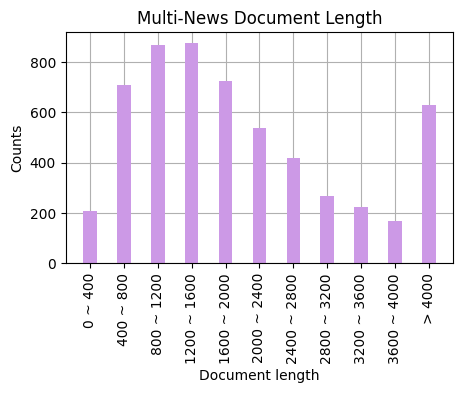

In [909]:
x = np.arange(len(counts))
y = counts

color1 = (0.8, 0.6, 0.9)
color2 = (79/255, 157/255, 166/255)

bar_width=0.4

fig, ax1 = plt.subplots(figsize=(5, 3))
plt.style.use('default')
ax1.grid(True, zorder=1)

ax1.bar(x, y, alpha=1.0, zorder=2, width=bar_width, color=color1, label="ratings")

# ax1.set_ylim(0.42, 0.53)

ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label, rotation=90)
# ax1.set_xticks

ax1.set_xlabel("Document length")
ax1.set_ylabel("Counts")

ax1.set_title("Multi-News Document Length")

In [902]:
# 定义区间
bins = np.arange(0, 4000, 400)

# 统计每个区间的出现次数
counts, edges = np.histogram(all_truncated_lengths, bins=bins)
counts = np.append(counts, (np.array(all_truncated_lengths)>3600).sum())

counts, edges

(array([186, 242, 375, 523, 647, 751, 886, 891, 793, 328]),
 array([   0,  400,  800, 1200, 1600, 2000, 2400, 2800, 3200, 3600]))

In [903]:
x_ticks_label = []
for i in range(len(edges)-1):
    x_ticks_label.append(f"{edges[i]} ~ {edges[i+1]}")

x_ticks_label.append(f"> {edges[-1]}")

x_ticks_label

['0 ~ 400',
 '400 ~ 800',
 '800 ~ 1200',
 '1200 ~ 1600',
 '1600 ~ 2000',
 '2000 ~ 2400',
 '2400 ~ 2800',
 '2800 ~ 3200',
 '3200 ~ 3600',
 '> 3600']

Text(0.5, 1.0, "PRIMERA's Truncation distribution")

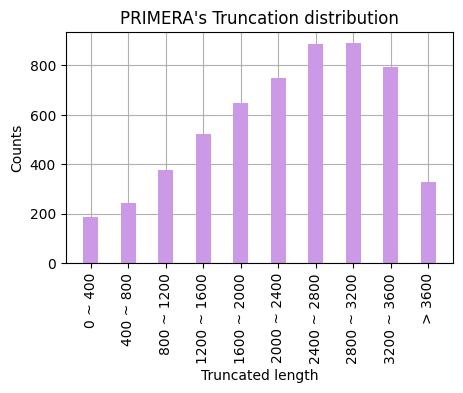

In [905]:
x = np.arange(len(counts))
y = counts

color1 = (0.8, 0.6, 0.9)
color2 = (79/255, 157/255, 166/255)

bar_width=0.4

fig, ax1 = plt.subplots(figsize=(5, 3))
plt.style.use('default')
ax1.grid(True, zorder=1)

ax1.bar(x, y, alpha=1.0, zorder=2, width=bar_width, color=color1, label="ratings")

# ax1.set_ylim(0.42, 0.53)

ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label, rotation=90)
# ax1.set_xticks

ax1.set_xlabel("Truncated length")
ax1.set_ylabel("Counts")

ax1.set_title("PRIMERA's Truncation distribution")

In [910]:
# per_doc_results_file = './script/run_saves/tsy_join_method_test_default/test_multi_news_4096_1024_beam=5_lenPen=1.00-0.csv'
# per_doc_results_file = './script/run_saves/tsy_join_method_test_original/test_multi_news_4096_1024_beam=5_lenPen=1.00-0.csv'
# per_doc_results_file = './script/run_saves/tsy_join_method_test_indoc_sim_sent_transformer/test_multi_news_4096_1024_beam=5_lenPen=1.00-0.csv'
per_doc_results_file = './script/run_saves/tsy_join_method_test_tsy_design/test_multi_news_4096_1024_beam=5_lenPen=1.00-0.csv'





per_doc_results = pd.read_csv(per_doc_results_file, index_col=0)


per_doc_rouge1_results = np.array(per_doc_results['rouge-1-f'])[:-1]
per_doc_rouge2_results = np.array(per_doc_results['rouge-2-f'])[:-1]
per_doc_rougeL_results = np.array(per_doc_results['rouge-L-f'])[:-1]

per_doc_results

rouge-1-r  rouge-1-p  rouge-1-f  rouge-2-r  rouge-2-p  rouge-2-f  \
0           0.531646   0.482759   0.506024   0.197452   0.179191   0.187879   
1           0.421965   0.557252   0.480263   0.174419   0.230769   0.198675   
2           0.610390   0.358779   0.451923   0.183007   0.107280   0.135266   
3           0.447853   0.454829   0.451314   0.086154   0.087500   0.086822   
4           0.555195   0.458445   0.502203   0.198697   0.163978   0.179676   
...              ...        ...        ...        ...        ...        ...   
5618        0.516432   0.384615   0.440882   0.188679   0.140351   0.160966   
5619        0.449219   0.534884   0.488323   0.172549   0.205607   0.187633   
5620        0.329114   0.156156   0.211813   0.012739   0.006024   0.008180   
5621        0.515504   0.547325   0.530938   0.190661   0.202479   0.196393   
avg_score   0.500516   0.525337   0.499545   0.205934   0.217500   0.206353   

           rouge-L-r  rouge-L-p  rouge-L-f  rouge-Lsum-r  rouge-Lsum-p  \
0           0.253165   0.229885   0.240964      0.253165      0.229885   
1           0.202312   0.267176   0.230263      0.202312      0.267176   
2           0.259740   0.152672   0.192308      0.259740      0.152672   
3           0.162577   0.165109   0.163833      0.162577      0.165109   
4           0.224026   0.184987   0.202643      0.224026      0.184987   
...              ...        ...        ...           ...           ...   
5618        0.230047   0.171329   0.196393      0.230047      0.171329   
5619        0.210938   0.251163   0.229299      0.210938      0.251163   
5620        0.170886   0.081081   0.109980      0.170886      0.081081   
5621        0.263566   0.279835   0.271457      0.263566      0.279835   
avg_score   0.256150   0.269557   0.255820      0.256150      0.269557   

           rouge-Lsum-f  
0              0.240964  
1              0.230263  
2              0.192308  
3              0.163833  
4              0.202643  
...                 ...  
5618           0.196393  
5619           0.229299  
5620           0.109980  
5621           0.271457  
avg_score      0.255820  

[5623 rows x 12 columns]

#### 对比target长度是多少，相对长度的效果对比

In [818]:
all_length_gap_rouge1_results = []
all_start_length = []

length_gap = 200
start_length = 200

all_start_length.append(0)
short_length_doc_ids = np.nonzero(np.array(all_documents_lengths) < start_length+np.array(all_summary_lengths))[0]
length_gap_rouge1 = per_doc_rouge1_results[short_length_doc_ids].mean()
print('less', start_length, short_length_doc_ids.shape[0], length_gap_rouge1)
all_length_gap_rouge1_results.append(length_gap_rouge1)

while start_length < 3000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length+np.array(all_summary_lengths),
                                               np.array(all_documents_lengths) < start_length+length_gap+np.array(all_summary_lengths)))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    start_length+=length_gap

length_gap = 500
while start_length < 4000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length+np.array(all_summary_lengths),
                                               np.array(all_documents_lengths) < start_length+length_gap+np.array(all_summary_lengths)))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    start_length+=length_gap

length_gap = 1000
while start_length < 5000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length+np.array(all_summary_lengths),
                                               np.array(all_documents_lengths) < start_length+length_gap+np.array(all_summary_lengths)))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    start_length+=length_gap

length_gap = 2000
while start_length < 7000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length+np.array(all_summary_lengths),
                                               np.array(all_documents_lengths) < start_length+length_gap+np.array(all_summary_lengths)))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    start_length+=length_gap

    
all_start_length.append(start_length)
long_length_doc_ids = np.nonzero(np.array(all_documents_lengths) >= start_length+np.array(all_summary_lengths))[0]
length_gap_rouge1 = per_doc_rouge1_results[long_length_doc_ids].mean()
all_length_gap_rouge1_results.append(length_gap_rouge1)
print(start_length, 'inf', long_length_doc_ids.shape[0], length_gap_rouge1)

less 200 230 0.4605705392170367
200 400 352 0.5179418480732361
400 600 425 0.5221460730191283
600 800 462 0.5189169620475441
800 1000 466 0.5103538133281982
1000 1200 437 0.5065288028070222
1200 1400 429 0.5072865149068685
1400 1600 381 0.4991366326632603
1600 1800 322 0.4993286506160974
1800 2000 269 0.4977587951926146
2000 2200 263 0.4940028666080691
2200 2400 215 0.4919420477573781
2400 2600 166 0.4858363103136516
2600 2800 135 0.49038914750406243
2800 3000 131 0.4828596777941805
3000 3500 242 0.4872301262583938
3500 4000 158 0.48282494802053094
4000 5000 191 0.4753373296737523
5000 7000 173 0.47625896183011035
7000 inf 175 0.4783628494916463


In [810]:
short_length_doc_ids = np.nonzero(np.array(all_documents_lengths) < 200+np.array(all_summary_lengths))[0]

median1_length_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= 200+np.array(all_summary_lengths),
                                                  np.array(all_documents_lengths) < 400+np.array(all_summary_lengths)))[0]
median2_length_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= 400+np.array(all_summary_lengths),
                                                  np.array(all_documents_lengths) < 600+np.array(all_summary_lengths)))[0]
median3_length_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= 600+np.array(all_summary_lengths),
                                                  np.array(all_documents_lengths) < 800+np.array(all_summary_lengths)))[0]
long_length_doc_ids = np.nonzero(np.array(all_documents_lengths) >= 2000+np.array(all_summary_lengths))[0]

short_length_doc_ids.shape, median1_length_doc_ids.shape, median2_length_doc_ids.shape, median3_length_doc_ids.shape, long_length_doc_ids.shape, \
per_doc_rouge1_results[short_length_doc_ids].mean(), per_doc_rouge1_results[median1_length_doc_ids].mean(), \
per_doc_rouge1_results[median2_length_doc_ids].mean(), per_doc_rouge1_results[median3_length_doc_ids].mean(), \
per_doc_rouge1_results[long_length_doc_ids].mean()

((230,),
 (352,),
 (425,),
 (462,),
 (1849,),
 0.45851581099866345,
 0.5131248019803567,
 0.5178990091542063,
 0.5165829675645555,
 0.48579501017373544)

#### 绝对长度是多少，绝对长度的效果对比

In [825]:
all_length_gap_rouge1_results = []
all_length_gap_rouge2_results = []
all_length_gap_rougeL_results = []
all_start_length = []


length_gap = 200
start_length = 400

all_start_length.append(0)
short_length_doc_ids = np.nonzero(np.array(all_documents_lengths) < start_length)[0]
length_gap_rouge1 = per_doc_rouge1_results[short_length_doc_ids].mean()
length_gap_rouge2 = per_doc_rouge2_results[short_length_doc_ids].mean()
length_gap_rougeL = per_doc_rougeL_results[short_length_doc_ids].mean()
print('less', start_length, short_length_doc_ids.shape[0], length_gap_rouge1)
all_length_gap_rouge1_results.append(length_gap_rouge1)
all_length_gap_rouge2_results.append(length_gap_rouge2)
all_length_gap_rougeL_results.append(length_gap_rougeL)

while start_length < 3000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length,
                                               np.array(all_documents_lengths) < start_length+length_gap))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    length_gap_rouge2 = per_doc_rouge2_results[median_length_gap_doc_ids].mean()
    length_gap_rougeL = per_doc_rougeL_results[median_length_gap_doc_ids].mean()
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    all_length_gap_rouge2_results.append(length_gap_rouge2)
    all_length_gap_rougeL_results.append(length_gap_rougeL)
    start_length+=length_gap

length_gap = 500
while start_length < 4000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length,
                                               np.array(all_documents_lengths) < start_length+length_gap))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    length_gap_rouge2 = per_doc_rouge2_results[median_length_gap_doc_ids].mean()
    length_gap_rougeL = per_doc_rougeL_results[median_length_gap_doc_ids].mean()
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    all_length_gap_rouge2_results.append(length_gap_rouge2)
    all_length_gap_rougeL_results.append(length_gap_rougeL)
    start_length+=length_gap

length_gap = 1000
while start_length < 5000:
    all_start_length.append(start_length)
    median_length_gap_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= start_length,
                                               np.array(all_documents_lengths) < start_length+length_gap))[0]
    length_gap_rouge1 = per_doc_rouge1_results[median_length_gap_doc_ids].mean()
    length_gap_rouge2 = per_doc_rouge2_results[median_length_gap_doc_ids].mean()
    length_gap_rougeL = per_doc_rougeL_results[median_length_gap_doc_ids].mean()
    print(start_length, start_length+length_gap, median_length_gap_doc_ids.shape[0], length_gap_rouge1)
    all_length_gap_rouge1_results.append(length_gap_rouge1)
    all_length_gap_rouge2_results.append(length_gap_rouge2)
    all_length_gap_rougeL_results.append(length_gap_rougeL)
    start_length+=length_gap


all_start_length.append(start_length)
long_length_doc_ids = np.nonzero(np.array(all_documents_lengths) >= start_length)[0]
length_gap_rouge1 = per_doc_rouge1_results[long_length_doc_ids].mean()
length_gap_rouge2 = per_doc_rouge2_results[long_length_doc_ids].mean()
length_gap_rougeL = per_doc_rougeL_results[long_length_doc_ids].mean()
print(start_length, 'inf', long_length_doc_ids.shape[0], length_gap_rouge1)
all_length_gap_rouge1_results.append(length_gap_rouge1)
all_length_gap_rouge2_results.append(length_gap_rouge2)
all_length_gap_rougeL_results.append(length_gap_rougeL)

less 400 205 0.4495232992863263
400 600 301 0.5084797613093892
600 800 406 0.5192242221317137
800 1000 421 0.5165597905408719
1000 1200 447 0.5079284764488867
1200 1400 456 0.5062561290333342
1400 1600 420 0.5090631612201894
1600 1800 393 0.4980434381051554
1800 2000 332 0.5000082542117136
2000 2200 288 0.5076564149873276
2200 2400 248 0.49909728274672416
2400 2600 234 0.4898874310499374
2600 2800 185 0.48440304375924953
2800 3000 142 0.49465253968266937
3000 3500 294 0.4867603671489004
3500 4000 220 0.4862419235352157
4000 5000 230 0.4818927568160995
5000 inf 400 0.47859507520572536


In [911]:
short_length_doc_ids = np.nonzero(np.array(all_documents_lengths) < 400)[0]

median_length_doc_ids = np.nonzero(np.logical_and(np.array(all_documents_lengths) >= 400,
                                                  np.array(all_documents_lengths) < 2400))[0]
long_length_doc_ids = np.nonzero(np.array(all_documents_lengths) >= 2400+np.array(all_summary_lengths))[0]

print(short_length_doc_ids.shape, median_length_doc_ids.shape, long_length_doc_ids.shape) 
print(f"{per_doc_rouge1_results[short_length_doc_ids].mean():.4f} {per_doc_rouge2_results[short_length_doc_ids].mean():.4f} {per_doc_rougeL_results[short_length_doc_ids].mean():.4f}")

print(f"{per_doc_rouge1_results[median_length_doc_ids].mean():.4f} {per_doc_rouge2_results[median_length_doc_ids].mean():.4f} {per_doc_rougeL_results[median_length_doc_ids].mean():.4f}")

print(f"{per_doc_rouge1_results[long_length_doc_ids].mean():.4f} {per_doc_rouge2_results[long_length_doc_ids].mean():.4f} {per_doc_rougeL_results[long_length_doc_ids].mean():.4f}")

(205,) (3712,) (1371,)
0.4516 0.2042 0.2744
0.5090 0.2204 0.2691
0.4823 0.1744 0.2238


#### draw figures about document lengths and rouge1 results
长度小于400的作为短文本\
长度大于400，小于2400的作为中文本\
长度为2400以上作为长文本，我们针对这部分文本进行优化

In [812]:
import matplotlib.pyplot as plt

In [813]:
x_ticks_label = []
for i in range(len(all_start_length)-1):
    x_ticks_label.append(f"{all_start_length[i]} ~ {all_start_length[i+1]}")

x_ticks_label.append(f"> {all_start_length[-1]}")

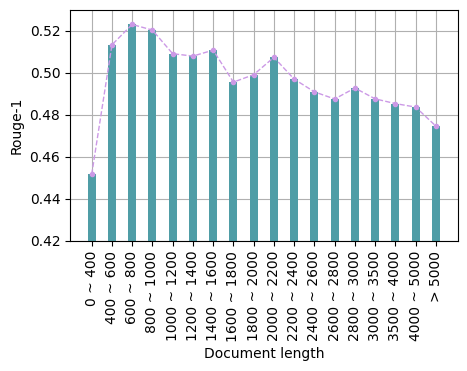

In [820]:
# x = np.array(all_start_length)
x = np.arange(len(all_start_length))
y = np.array(all_length_gap_rouge1_results)

color1 = (0.8, 0.6, 0.9)
color2 = (79/255, 157/255, 166/255)

bar_width=0.4

fig, ax1 = plt.subplots(figsize=(5, 3))
plt.style.use('default')
ax1.grid(True, zorder=1)

ax1.bar(x, y, alpha=1.0, zorder=2, width=bar_width, color=color2, label="ratings")
ax1.plot(x, y, alpha=1.0, zorder=2, color=color1, linestyle='--', linewidth=1, 
         marker='.', markersize=6, label="ratings")

ax1.set_ylim(0.42, 0.53)

ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label, rotation=90)
# ax1.set_xticks

ax1.set_xlabel("Document length")
ax1.set_ylabel("Rouge-1")


# plt.show()
file_name = f'./figures/tsy_design-rouge1'
plt.savefig(file_name+'.eps', dpi=100, bbox_inches = 'tight')
plt.savefig(file_name+'.png', dpi=100, bbox_inches = 'tight')

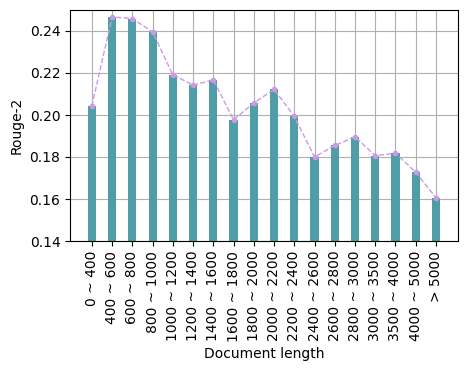

In [821]:
# x = np.array(all_start_length)
x = np.arange(len(all_start_length))
y = np.array(all_length_gap_rouge2_results)


color1 = (0.8, 0.6, 0.9)
color2 = (79/255, 157/255, 166/255)

bar_width=0.4

fig, ax1 = plt.subplots(figsize=(5, 3))
plt.style.use('default')
ax1.grid(True, zorder=1)

ax1.bar(x, y, alpha=1.0, zorder=2, width=bar_width, color=color2, label="ratings")
ax1.plot(x, y, alpha=1.0, zorder=2, color=color1, linestyle='--', linewidth=1, 
         marker='.', markersize=6, label="ratings")

ax1.set_ylim(0.14, 0.25)

ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label, rotation=90)
# ax1.set_xticks

ax1.set_xlabel("Document length")
ax1.set_ylabel("Rouge-2")

# plt.show()
file_name = f'./figures/tsy_design-rouge2'
plt.savefig(file_name+'.eps', dpi=100, bbox_inches = 'tight')
plt.savefig(file_name+'.png', dpi=100, bbox_inches = 'tight')

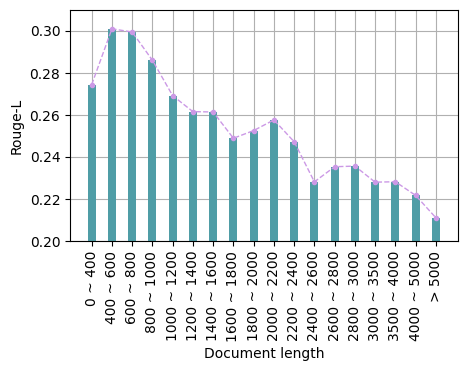

In [822]:
# x = np.array(all_start_length)
x = np.arange(len(all_start_length))
y = np.array(all_length_gap_rougeL_results)


color1 = (0.8, 0.6, 0.9)
color2 = (79/255, 157/255, 166/255)

bar_width=0.4

fig, ax1 = plt.subplots(figsize=(5, 3))
plt.style.use('default')
ax1.grid(True, zorder=1)

ax1.bar(x, y, alpha=1.0, zorder=2, width=bar_width, color=color2, label="ratings")
ax1.plot(x, y, alpha=1.0, zorder=2, color=color1, linestyle='--', linewidth=1, 
         marker='.', markersize=6, label="ratings")

ax1.set_ylim(0.2, 0.31)

ax1.set_xticks(x)
ax1.set_xticklabels(x_ticks_label, rotation=90)
# ax1.set_xticks

ax1.set_xlabel("Document length")
ax1.set_ylabel("Rouge-L")

# plt.show()
file_name = f'./figures/tsy_design-rougeL'
plt.savefig(file_name+'.eps', dpi=100, bbox_inches = 'tight')
plt.savefig(file_name+'.png', dpi=100, bbox_inches = 'tight')